In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import pathlib
import glob

import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp
import equinox as eqx
import optax


In [3]:
from mc2.utils.data_inspection import (
    get_available_material_names,
    get_file_overview,
    filter_file_overview,
    load_single_file,
    load_and_process_single_from_full_file_overview,
)
from mc2.utils.data_plotting import plot_single_sequence
from mc2.data_management import FrequencySet, MaterialSet, DataSet, NormalizedFrequencySet, load_data_into_pandas_df
from mc2.features.features_jax import add_fe

In [4]:
from mc2.training.jax_routine import train_model

#gpus = jax.devices()
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
#jax.config.update("jax_default_device", gpus[0])

In [5]:
from mc2.models.model_interface import ModelInterface, RNNwInterface
from mc2.models.RNN import GRU

In [6]:
from mc2.features.features_jax import compute_fe_single
def featurize(norm_B_past, norm_H_past, norm_B_future, temperature):
    past_length = norm_B_past.shape[0]
    future_length = norm_B_future.shape[0]

    featurized_B = compute_fe_single(jnp.hstack([norm_B_past, norm_B_future]), n_s=10)

    return featurized_B[past_length:]

#feature_names=["original_b","db_dt","d2b_dt2","dyn_avg","pwm_of_b"] #,"frequency"]

In [7]:
#Adjoint method for estimating Jiles-Atherton hysteresis
#model parameters

#On physical aspects of the Jiles-Atherton hysteresis models
def softclip(x, limit=1e8):
    return limit * jnp.tanh(x / limit)

def softplus(x, eps=1e-6):
    return jnp.log1p(jnp.exp(x)) + eps

class JilesAthertonStatic(eqx.Module):
    Ms_param: jax.Array
    a_param: jax.Array
    alpha_param: jax.Array
    k_param: jax.Array
    c_param: jax.Array
    mu_0: float = 4e-7 * jnp.pi
    tau: float = 1/16e6

    @property
    def a(self):
        return 3000*jax.nn.sigmoid(self.a_param)

    @property
    def alpha(self):
        return jax.nn.sigmoid(self.alpha_param)

    @property
    def k(self):
        return 150.0 *jax.nn.sigmoid(self.k_param)

    @property
    def c(self):
        return jax.nn.sigmoid(self.c_param)
    
    @property
    def Ms(self):
        return 1e6*jax.nn.sigmoid(self.Ms_param)

    def __init__(self, key, **kwargs):
        super().__init__(**kwargs)
        k_key, alpha_key, c_key, Ms_key, a_key = jax.random.split(key, 5)
        self.k_param = jax.random.uniform(k_key, ()) * 0.05 + 0.5
        self.c_param = jax.random.uniform(c_key, ()) * 0.05 + 0.5
        self.a_param = jax.random.uniform(a_key, ()) * 0.05 + 0.5
        self.Ms_param = jnp.array(0.5)
        self.alpha_param= jax.random.uniform(alpha_key, ())*0.001 + 0.0002

    def coth(self,x):
        return 1/ jnp.tanh(x)
    
    def coth_stable(self,x):
        eps = 1e-7
        x = jnp.where(jnp.abs(x) < eps, eps*jnp.sign(x), x)
        return 1/jnp.tanh(x)

    # Updated dM_dH function
    def dM_dH(self, H, M, dB_dt):
        H_e = H + self.alpha * M
        M_an = self.Ms * (self.coth_stable(H_e/self.a) - self.a/H_e)
        delta_m = 0.5*(1+jnp.sign((M_an-M)*dB_dt))

        dM_an_dH_e = self.Ms / self.a * (1 - (self.coth_stable(H_e/self.a))**2 + (self.a/H_e)**2)
        delta = jnp.sign(dB_dt)
        
        numerator = delta_m * (M_an - M) + self.c * self.k * delta * dM_an_dH_e
        denominator = self.k * delta - self.alpha * numerator
        
        dM_dH = numerator / denominator
        
        return dM_dH
    
    def ode(self, B, B_next, H):
        dB_dt_est = (B_next - B) / self.tau
        M = B / self.mu_0 - H
        dM_dH = self.dM_dH(H, M, dB_dt_est)
        dM_dB = dM_dH / (self.mu_0 * (1 + dM_dH))
        dM_dt = dM_dB * dB_dt_est
        dH_dt = 1/self.mu_0 * dB_dt_est - dM_dt

        dH_dt = softclip(dH_dt, limit=1e8)
        
        return dH_dt, dB_dt_est

    def step(self, H, B, B_next):
        dH_dt, _ = self.ode(B, B_next, H)
        H_next = H + self.tau * dH_dt
        B_next = B_next
        return H_next, B_next

    def __call__(self, H0, B_seq):
        
        def body_fun(carry, B_pair):
            H_prev = carry
            B_curr, B_next = B_pair
            H_next, _ = self.step(H_prev, B_curr, B_next)
            return H_next, H_next

        B_pairs = jnp.stack([B_seq[:-1], B_seq[1:]], axis=1)
        _, H_seq = jax.lax.scan(body_fun, H0, B_pairs)
        H_seq = jnp.concatenate([jnp.array([H0]), H_seq], axis=0)
        return H_seq

In [8]:
#Adjoint method for estimating Jiles-Atherton hysteresis
#model parameters

#On physical aspects of the Jiles-Atherton hysteresis models
def softclip(x, limit=1e8):
    return limit * jnp.tanh(x / limit)

def softplus(x, eps=1e-6):
    return jnp.log1p(jnp.exp(x)) + eps

class JilesAthertonAdv(eqx.Module):
    Ms_param: jax.Array  = eqx.static_field()
    a_param: jax.Array  = eqx.static_field()
    alpha_param: jax.Array  = eqx.static_field()
    k_param: jax.Array  = eqx.static_field()
    c_param: jax.Array  = eqx.static_field()
    mlp: eqx.nn.MLP
    mu_0: float = 4e-7 * jnp.pi
    tau: float = 1/16e6

    def __init__(self, key, in_dim: int, width: int = 16, depth: int = 1,
                 Ms_param=None, a_param=None, alpha_param=None, k_param=None, c_param=None, **kwargs):
        super().__init__(**kwargs)
        
        self.Ms_param = jnp.array(0.5) if Ms_param is None else Ms_param
        self.a_param = jnp.array(0.5) if a_param is None else a_param
        self.alpha_param = jnp.array(0.001) if alpha_param is None else alpha_param
        self.k_param = jnp.array(0.5) if k_param is None else k_param
        self.c_param = jnp.array(0.5) if c_param is None else c_param
        self.mlp = eqx.nn.MLP(
                in_size=in_dim,
                out_size=5,
                width_size=width,
                depth=depth,
                key=key,
                activation=jax.nn.leaky_relu, #jax.nn.tanh
                final_activation=jax.nn.tanh
            )

    def coth(self,x):
        return 1/ jnp.tanh(x)
    
    def coth_stable(self,x):
        eps = 1e-7
        x = jnp.where(jnp.abs(x) < eps, eps*jnp.sign(x), x)
        return 1/jnp.tanh(x)

    def _predict_params(self, x):
        scalings = self.mlp(x)  # shape (5,)
        Ms_scale, a_scale, alpha_scale, k_scale, c_scale = scalings

        Ms = 1e6 * jax.nn.sigmoid(self.Ms_param) *(1+Ms_scale*0.5)
        a = 3000 * jax.nn.sigmoid(self.a_param) *(1+a_scale*0.5)
        alpha = jax.nn.sigmoid(self.alpha_param) *(1+alpha_scale*0.5)
        k = 150.0 * jax.nn.sigmoid(self.k_param) *(1+k_scale*0.5)
        c = jax.nn.sigmoid(self.c_param) *(1+c_scale)
        return Ms, a, alpha, k, c
    
    def dM_dH(self, H, M, dB_dt,params):
        Ms, a, alpha, k, c= params
        H_e = H + alpha * M
        M_an = Ms * (self.coth_stable(H_e/a) - a/H_e)
        delta_m = 0.5*(1+jnp.sign((M_an-M)*dB_dt))

        dM_an_dH_e = Ms / a * (1 - (self.coth_stable(H_e/a))**2 + (a/H_e)**2)
        delta = jnp.sign(dB_dt)
        
        numerator = delta_m * (M_an - M) + c * k * delta * dM_an_dH_e
        denominator = k * delta - alpha * numerator
        
        dM_dH = numerator / denominator
        
        return dM_dH
    
    def ode(self, B, B_next, H,params):
        dB_dt_est = (B_next - B) / self.tau
        M = B / self.mu_0 - H
        dM_dH = self.dM_dH(H, M, dB_dt_est,params)
        dM_dB = dM_dH / (self.mu_0 * (1 + dM_dH))
        dM_dt = dM_dB * dB_dt_est
        dH_dt = 1/self.mu_0 * dB_dt_est - dM_dt

        dH_dt = softclip(dH_dt, limit=1e8)
        
        return dH_dt, dB_dt_est

    def step(self, H, B, B_next, features):
        params=self._predict_params(features)
        dH_dt, _ = self.ode(B, B_next, H,params)
        H_next = H + self.tau * dH_dt
        B_next = B_next
        return H_next, B_next

    def __call__(self, H0, B_seq, features):
        B_pairs = jnp.stack([B_seq[:-1], B_seq[1:]], axis=1)
        feat_pairs = features[1:]   

        def body_fun(H_prev, inputs):
            (B_curr, B_next), feat = inputs
            H_next, _ = self.step(H_prev, B_curr, B_next, feat)
            return H_next, H_next

        _, H_seq = jax.lax.scan(body_fun, H0, (B_pairs, feat_pairs))
        H_seq = jnp.concatenate([jnp.array([H0]), H_seq], axis=0)
        return H_seq

In [9]:
from typing import Callable
class JAwJAInterface(ModelInterface):
    model: JilesAthertonStatic
    normalizer: eqx.Module
    featurize: Callable = eqx.field(static=True)

    def __call__(self, B_past, H_past, B_future, T):
        B_all = jnp.concatenate([B_past, B_future], axis=1)
        B_all_norm, H_past_norm, T_norm = self.normalizer.normalize(B_all, H_past, T)
        B_past_norm = B_all_norm[:, : B_past.shape[1]]
        B_future_norm = B_all_norm[:, B_past.shape[1]:]
        batch_H_pred_norm = self.normalized_call(B_past_norm, H_past_norm, B_future_norm,T_norm)
        batch_H_pred_denorm = jax.vmap(jax.vmap(self.normalizer.denormalize_H))(batch_H_pred_norm)
        return batch_H_pred_denorm

    def normalized_call(self, B_past_norm, H_past_norm, B_future_norm,T_norm):
        B_all_norm = jnp.concatenate([B_past_norm, B_future_norm], axis=1)
        B_all, H_past, T = self.normalizer.denormalize(B_all_norm, H_past_norm, T_norm)
        B_past = B_all[:, : B_past_norm.shape[1]]
        B_future = B_all[:, B_past_norm.shape[1]:]
        H0 = H_past[:, -1]  
        def single_batch(H0_i, B_future_i):
            H_seq_i = self.model(H0_i, B_future_i)
            return H_seq_i
        batch_H_pred = jax.vmap(single_batch)(H0, B_future)
        batch_H_pred_norm = jax.vmap(jax.vmap(self.normalizer.normalize_H))(batch_H_pred)
        return batch_H_pred_norm
    
from typing import Callable
class JAwJAInterfaceAdv(ModelInterface):
    model: JilesAthertonAdv
    normalizer: eqx.Module
    featurize: Callable = eqx.field(static=True)

    def __call__(self, B_past, H_past, B_future, T):
        B_all = jnp.concatenate([B_past, B_future], axis=1)
        B_all_norm, H_past_norm, T_norm = self.normalizer.normalize(B_all, H_past, T)
        B_past_norm = B_all_norm[:, : B_past.shape[1]]
        B_future_norm = B_all_norm[:, B_past.shape[1]:]
        batch_H_pred_norm = self.normalized_call(B_past_norm, H_past_norm, B_future_norm,T_norm)
        batch_H_pred_denorm = jax.vmap(jax.vmap(self.normalizer.denormalize_H))(batch_H_pred_norm)
        return batch_H_pred_denorm

    def normalized_call(self, B_past_norm, H_past_norm, B_future_norm,T_norm):
        features = jax.vmap(self.featurize, in_axes=(0, 0, 0, 0))(
            B_past_norm, H_past_norm, B_future_norm, T_norm
        )  # ,None , f_norm
        features_norm = jax.vmap(jax.vmap(self.normalizer.normalize_fe))(features)

        T_norm_broad = jnp.broadcast_to(T_norm[:, None], B_future_norm.shape)
        # f_norm_broad= jnp.broadcast_to(jnp.array([f_norm]), B_future_norm.shape)

        batch_x = jnp.concatenate(
            [B_future_norm[..., None], T_norm_broad[..., None], features_norm], axis=-1
        )
        B_all_norm = jnp.concatenate([B_past_norm, B_future_norm], axis=1)
        B_all, H_past, T = self.normalizer.denormalize(B_all_norm, H_past_norm, T_norm)
        B_past = B_all[:, : B_past_norm.shape[1]]
        B_future = B_all[:, B_past_norm.shape[1]:]
        H0 = H_past[:, -1]  
        def single_batch(H0_i, B_future_i,features):
            H_seq_i = self.model(H0_i, B_future_i,features)
            return H_seq_i
        batch_H_pred = jax.vmap(single_batch)(H0, B_future,batch_x)
        batch_H_pred_norm = jax.vmap(jax.vmap(self.normalizer.normalize_H))(batch_H_pred)
        return batch_H_pred_norm

In [10]:
data_dict = load_data_into_pandas_df(material="3C90")
mat_set = MaterialSet.from_pandas_dict(data_dict)
train_set, val_set, test_set = mat_set.split_into_train_val_test(
    train_frac=0.7, val_frac=0.15, test_frac=0.15, seed=12
)
train_set_norm = train_set.normalize(transform_H=True, featurize=featurize) #, feature_names=feature_names


Loading data for 3C90:   0%|          | 0/21 [00:00<?, ?it/s]

Loading data for 3C90: 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]
INFO:2025-09-25 11:54:17,812:jax._src.xla_bridge:925: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


2025-09-25 11:54:17 | INFO : Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


INFO:2025-09-25 11:54:17,815:jax._src.xla_bridge:925: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


2025-09-25 11:54:17 | INFO : Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


## Static Training

In [11]:
seed = 6
key = jax.random.PRNGKey(seed)
key, model_key = jax.random.split(key, 2)

ja_model_static = JilesAthertonStatic(key=model_key)
optimizer = optax.adam(1e-3)
ja_wrap_static=JAwJAInterface(model=ja_model_static, normalizer=train_set_norm.normalizer, featurize=featurize)

In [12]:
logs, model_static = train_model(
    model=ja_wrap_static,
    optimizer=optimizer,
    n_epochs=5,
    n_steps=0,
    material_name="3C90",
    data_tuple=(train_set, val_set, test_set),
    tbptt_size=20,#, #50
    batch_size=64,
    val_every=1,
    past_size=20,
    key=key,
    seed=seed,
)

2025-09-25 11:54:49 | INFO : train size: 12075, val size: 2596, test size: 2598


2025-09-25 11:54:54 | INFO : Test loss seed 6: inf A/m


Seed 6:   0%|          | 0/5 [00:00<?, ?epoch/s]

2025-09-25 11:58:02 | INFO : Test loss seed 6: 280.045427 A/m


Parameter |        ja_model |     model.model
---------------------------------------------
      Ms |    6.224593e+05 |    9.324345e+05
   alpha |    5.001025e-01 |    3.947816e-03
       a |    1.900218e+03 |    1.259911e+03
       k |    9.409462e+01 |    1.499978e+02
       c |    6.295764e-01 |    9.469500e-01


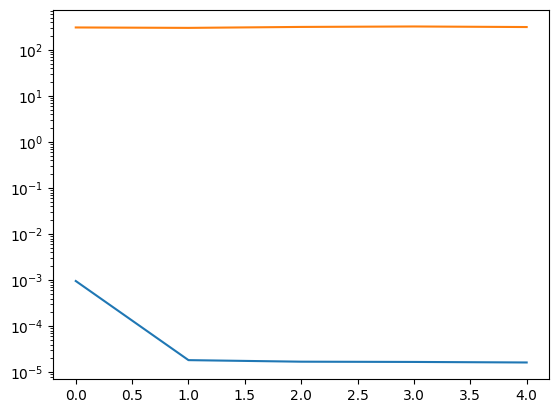

In [13]:
print(f"{'Parameter':>8} | {'ja_model':>15} | {'model.model':>15}")
print("-"*45)

params = ["Ms", "alpha", "a", "k", "c"]

for p in params:
    ja_val = getattr(ja_wrap_static.model, p)
    model_val = getattr(model_static.model, p)
    print(f"{p:>8} | {ja_val:15.6e} | {model_val:15.6e}")
plt.plot(logs["loss_trends_train"],label="train_loss")
plt.plot(logs["loss_trends_val"],label="val_loss")
plt.yscale("log")


Frequency in Hz:  50000.0


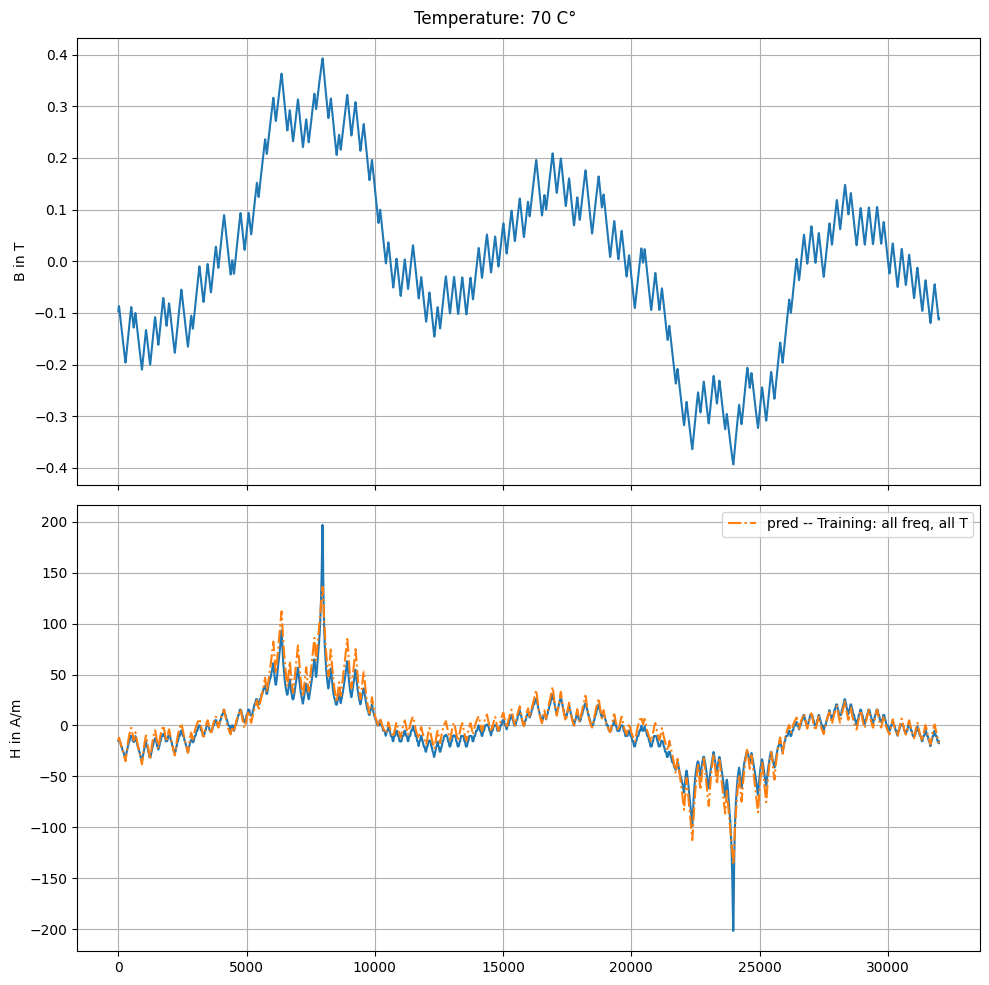

Frequency in Hz:  80000.0


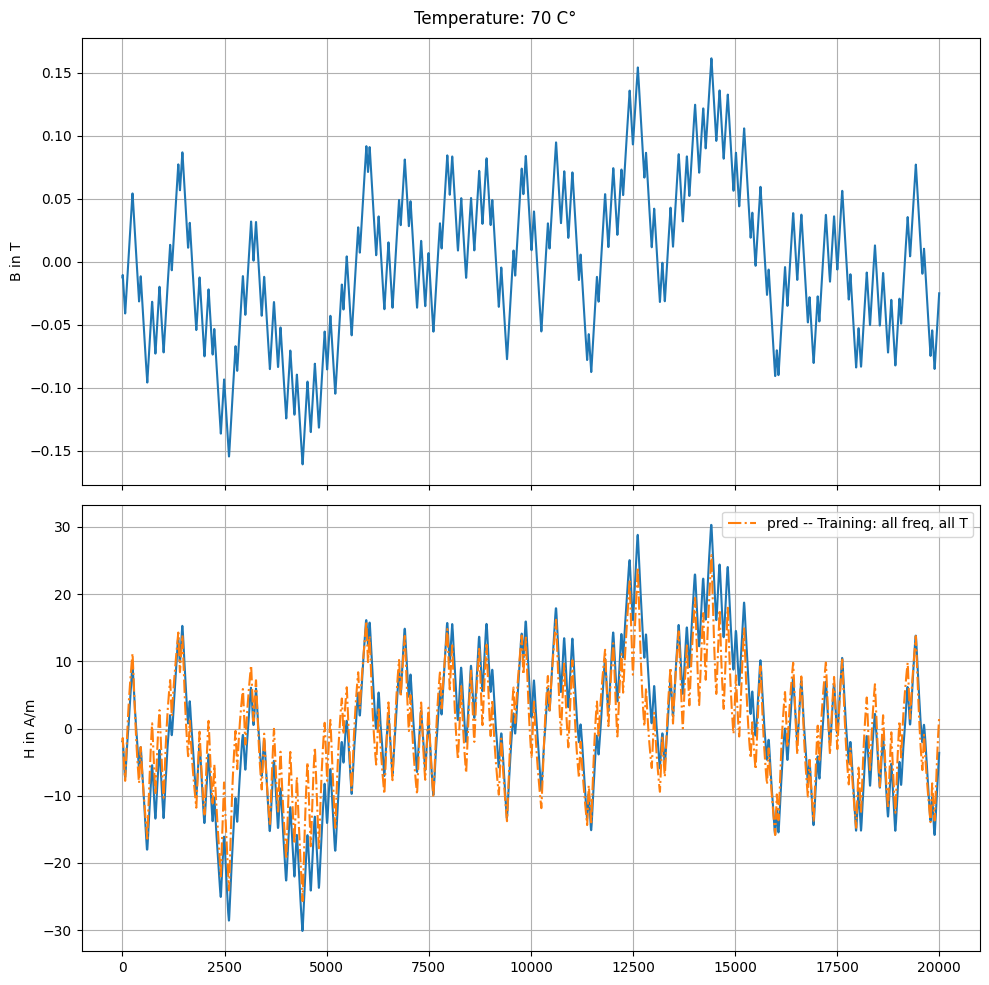

Frequency in Hz:  125000.0


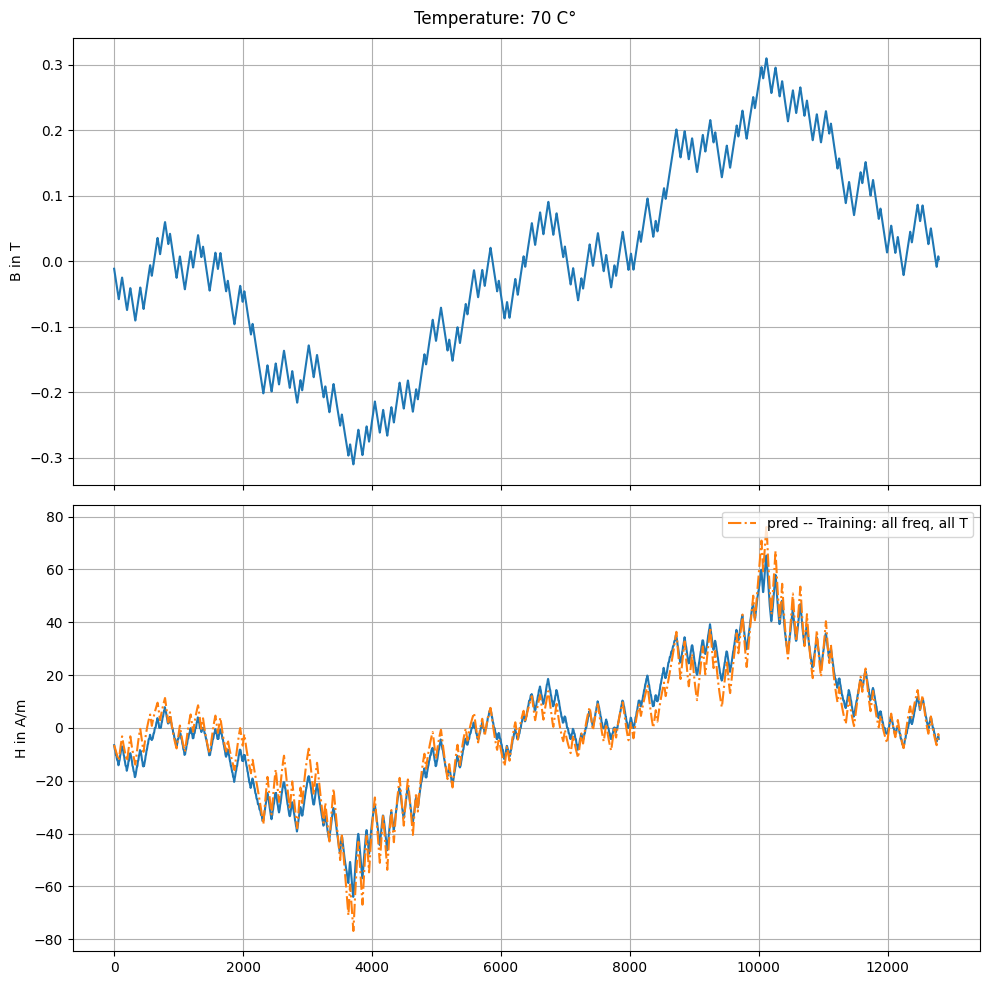

Frequency in Hz:  200000.0


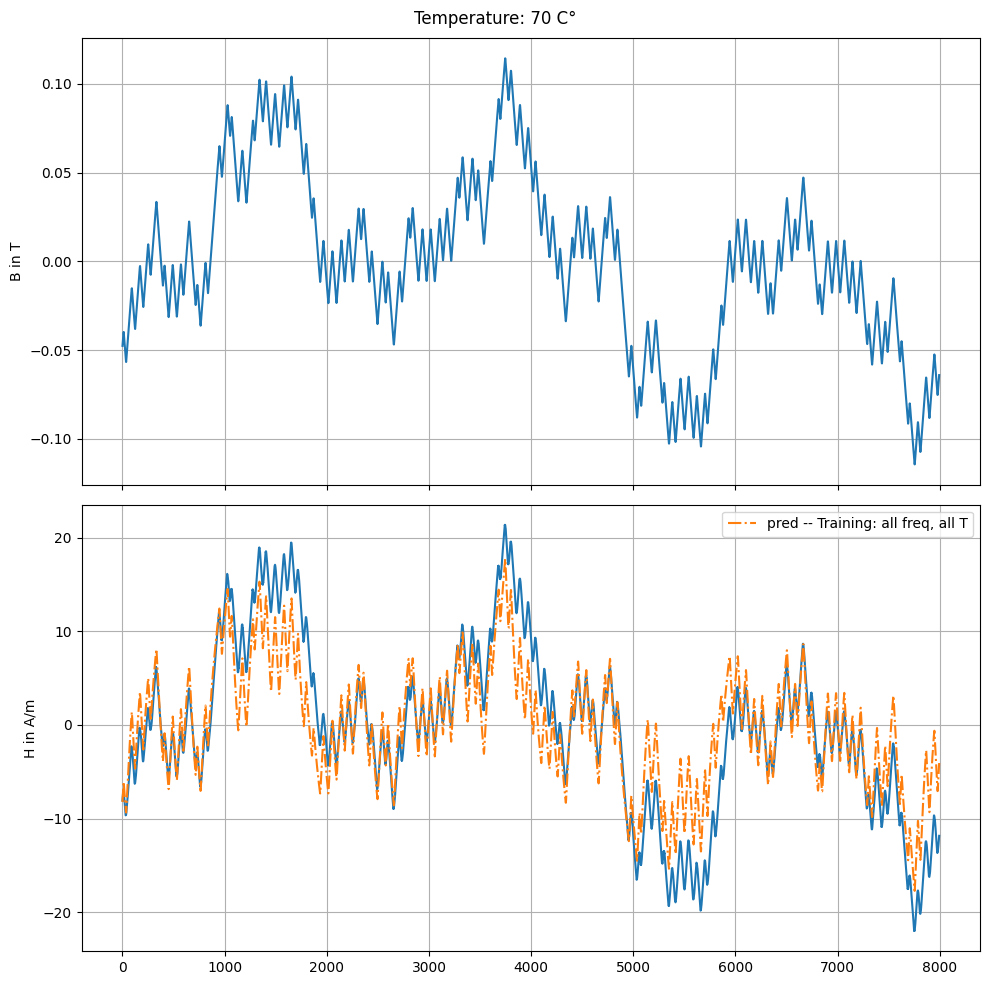

Frequency in Hz:  320000.0


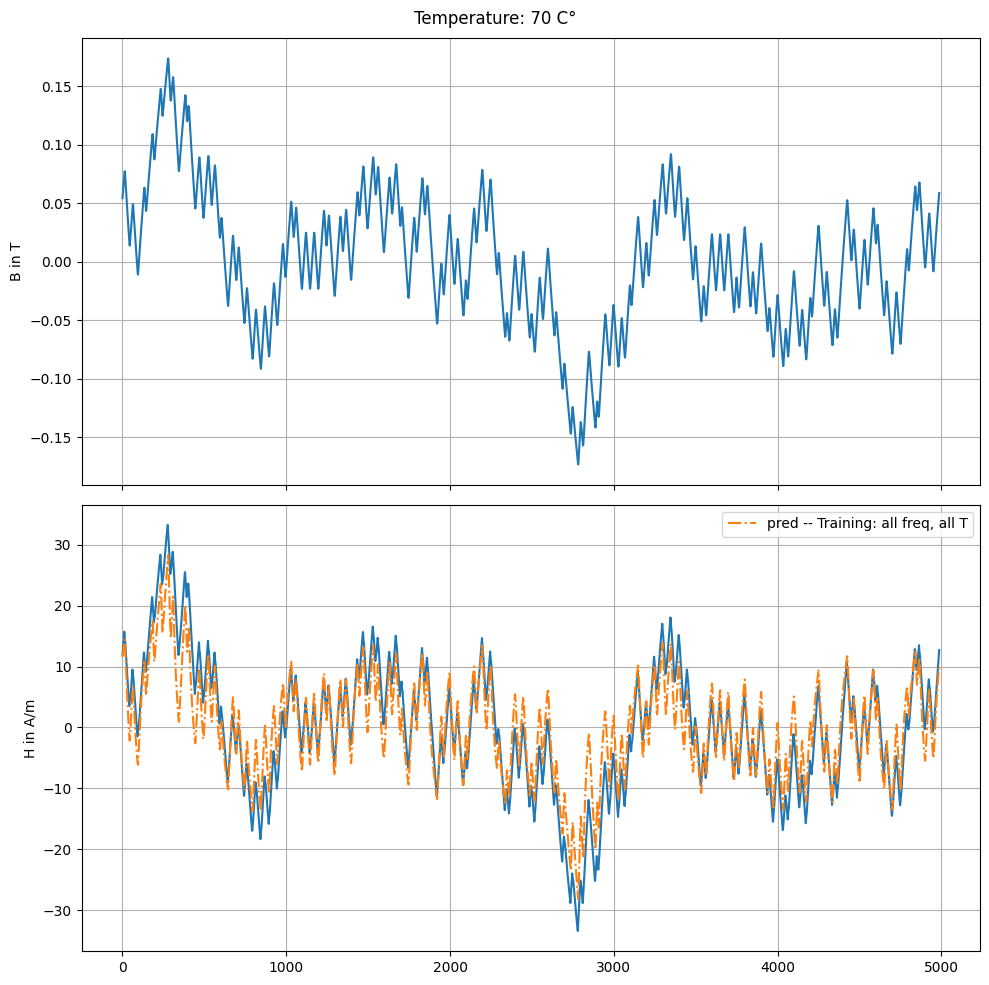

Frequency in Hz:  500000.0


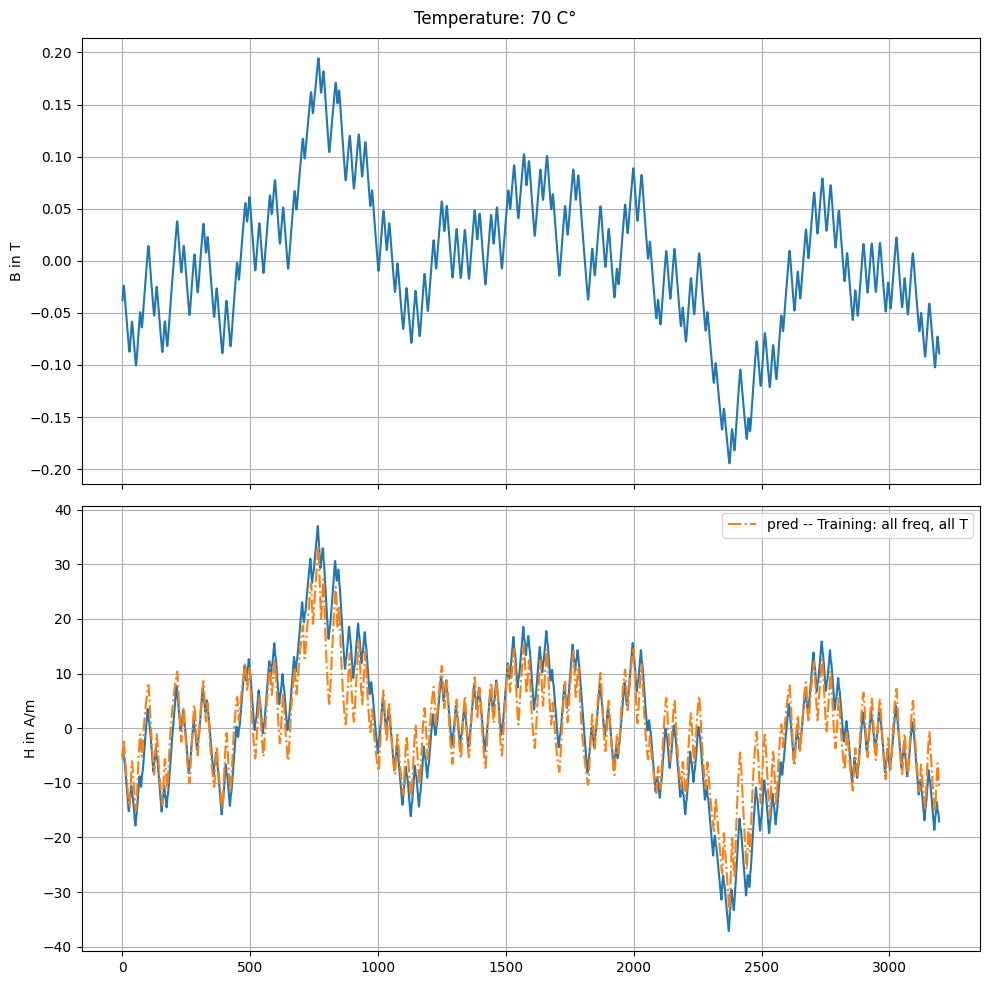

Frequency in Hz:  800000.0


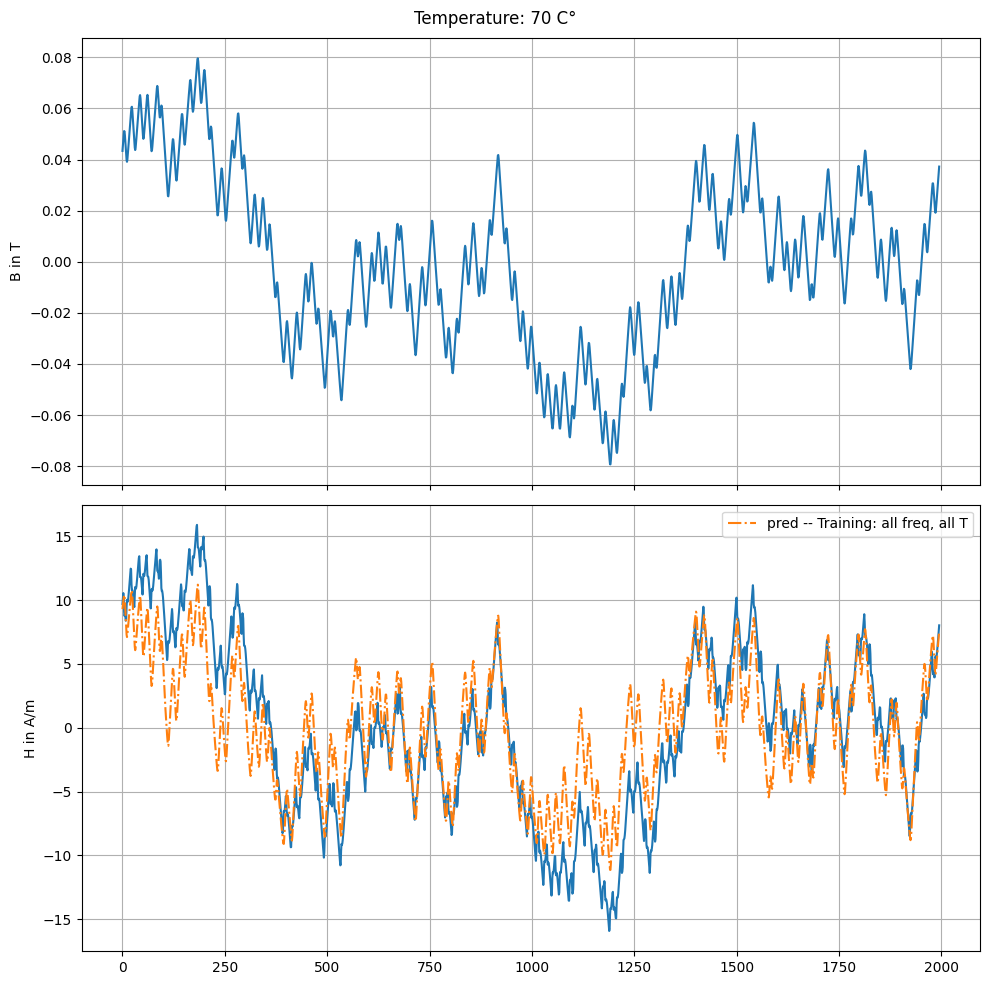

In [ ]:
model_all = model_static
test_set_T=test_set.filter_temperatures([25,50,70])
for frequency_idx in [0,1,2,3,4,5,6]:
    batch_idx=jnp.array([0])
    print("Frequency in Hz: ",test_set_T.frequencies[frequency_idx])
    H_pred_all = model_all(
        B_past=test_set_T[frequency_idx].B[batch_idx, :20],
        H_past=test_set_T[frequency_idx].H[batch_idx, :20],
        B_future=test_set_T[frequency_idx].B[batch_idx, 20:],
        T=test_set_T[frequency_idx].T[batch_idx]
    )#
    for H_p_all, H, B,T in zip(H_pred_all, test_set_T[frequency_idx].H[batch_idx, 20:], test_set_T[frequency_idx].B[batch_idx, 20:], test_set_T[frequency_idx].T[batch_idx]):

        fig, axs = plot_single_sequence(B, H, T)
        #axs[-1].plot(H_p_T_f, label="pred -- Training: freq=500_000, T=50",linestyle="--")
        #axs[-1].plot(H_p_T, label="pred -- Training: freq=500_000, all T",linestyle="-.")
        axs[-1].plot(H_p_all, label="pred -- Training: all freq, all T",linestyle="-.")
        #axs[-1].set_title(test_set_T.frequencies[frequency_idx])
        axs[-1].legend(loc="upper right")
        plt.show()

In [15]:
eqx.tree_serialise_leaves("temp_data/model_static0.eqx", model_static)

## Using static results for dynamic extension

In [16]:
# hidden_size = 8
# in_size = 7#8
# out_size = 1
seed = 6
key = jax.random.PRNGKey(seed)
key, model_key = jax.random.split(key, 2)
Ms_param=model_static.model.Ms_param
a_param=model_static.model.a_param
alpha_param=model_static.model.alpha_param
k_param=model_static.model.k_param
c_param=model_static.model.c_param
ja_model_dyn = JilesAthertonAdv(key=model_key,in_dim=7,depth=2,width=32,Ms_param=Ms_param,a_param=a_param,alpha_param=alpha_param,k_param=k_param,c_param=c_param)
optimizer = optax.adam(1e-3)

/tmp/ipykernel_1042392/127076839.py:12: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  ja_model_dyn = JilesAthertonAdv(key=model_key,in_dim=7,depth=2,width=32,Ms_param=Ms_param,a_param=a_param,alpha_param=alpha_param,k_param=k_param,c_param=c_param)


In [17]:
ja_wrap_dyn=JAwJAInterfaceAdv(model=ja_model_dyn, normalizer=train_set_norm.normalizer, featurize=featurize)

In [22]:
logs, model_dyn = train_model(
    model=ja_wrap_dyn,
    optimizer=optimizer,
    n_epochs=10,
    n_steps=0,
    material_name="3C90",
    data_tuple=(train_set, val_set, test_set),
    tbptt_size=20,#, #50
    batch_size=64,
    val_every=1,
    past_size=20,
    key=key,
    seed=seed,
)

2025-09-25 12:11:27 | INFO : train size: 12075, val size: 2596, test size: 2598


2025-09-25 12:11:44 | INFO : Test loss seed 6: 1637.271652 A/m


Seed 6:   0%|          | 0/10 [00:00<?, ?epoch/s]

2025-09-25 12:35:18 | INFO : Test loss seed 6: 73.366202 A/m


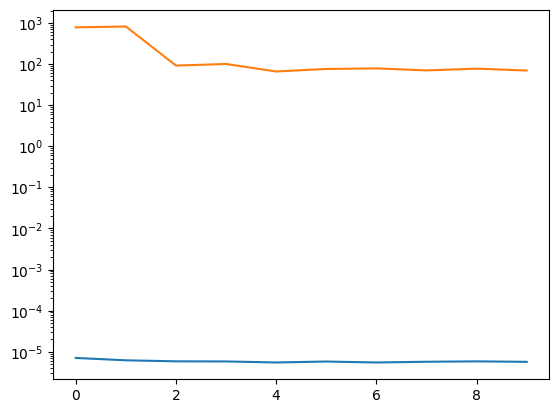

In [23]:
plt.plot(logs["loss_trends_train"],label="train_loss")
plt.plot(logs["loss_trends_val"],label="val_loss")
plt.yscale("log")

In [ ]:
eqx.tree_serialise_leaves("temp_data/model_dyn1.eqx", model_dyn)

Frequency in Hz:  50000.0


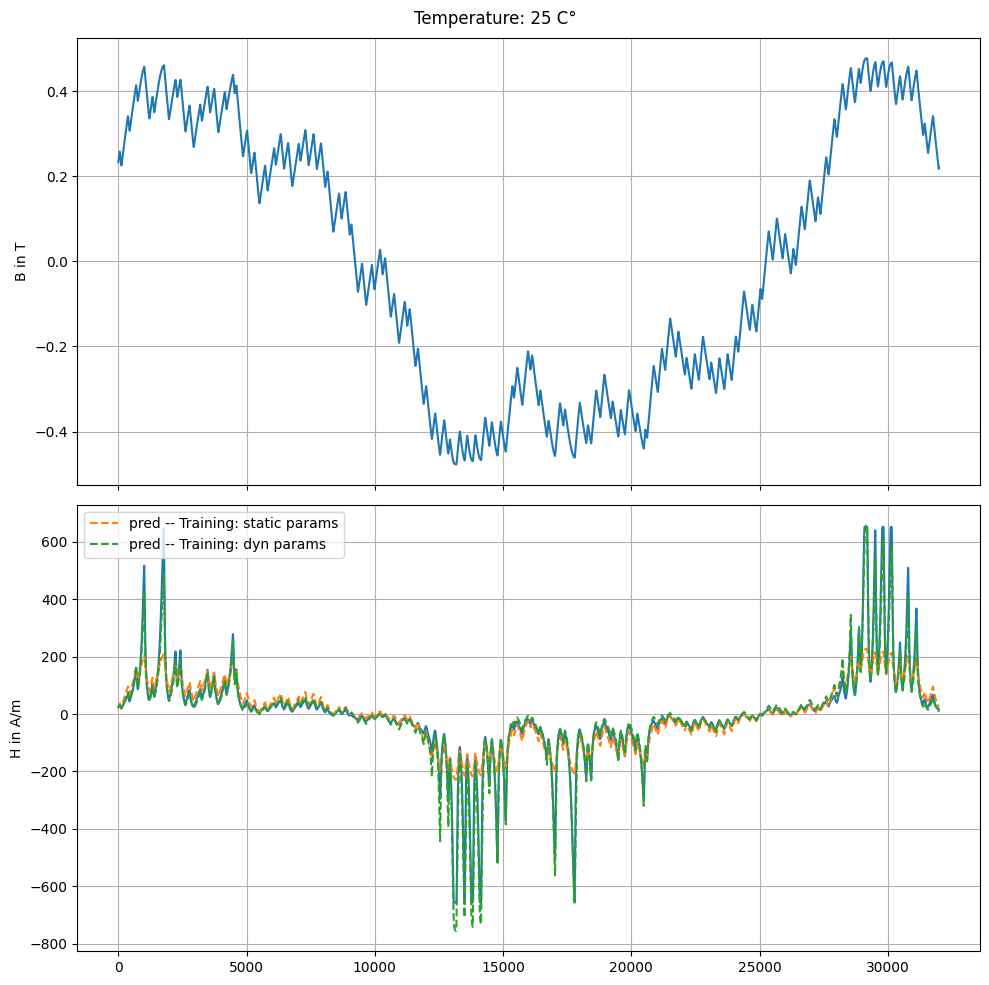

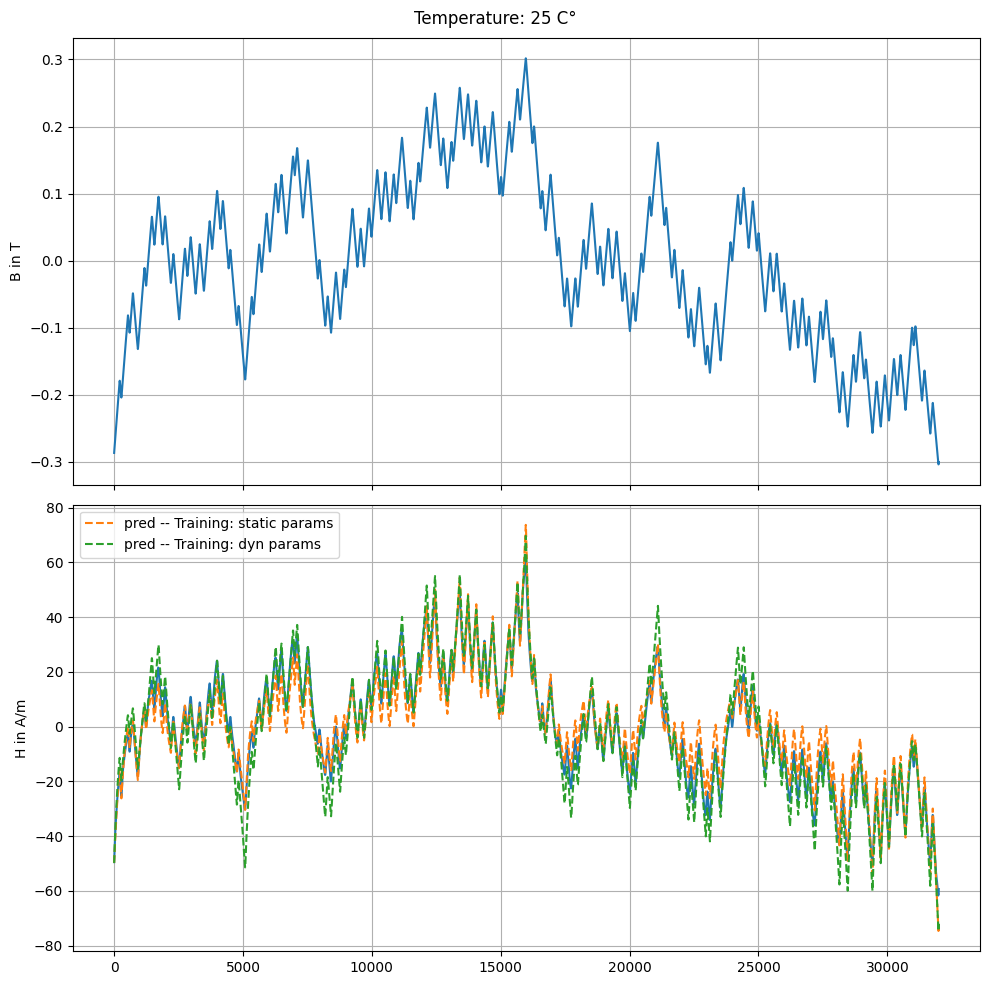

Frequency in Hz:  80000.0


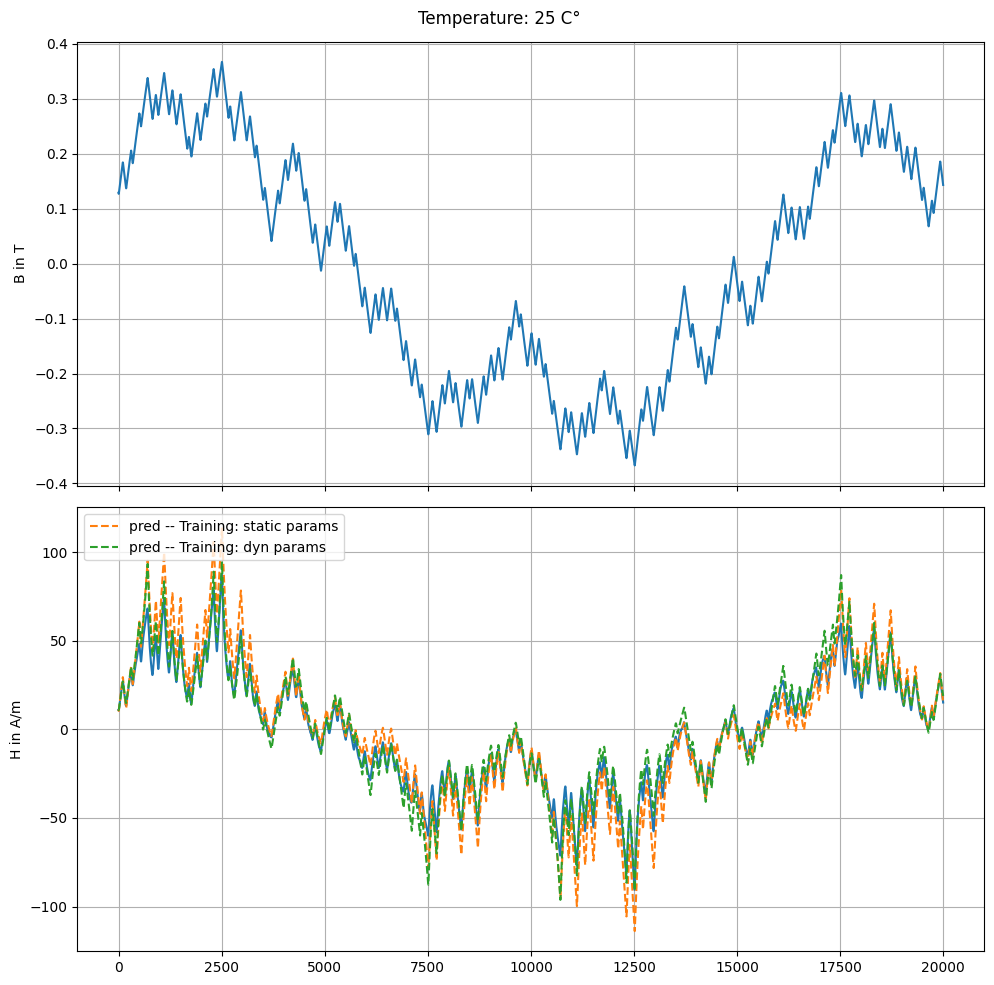

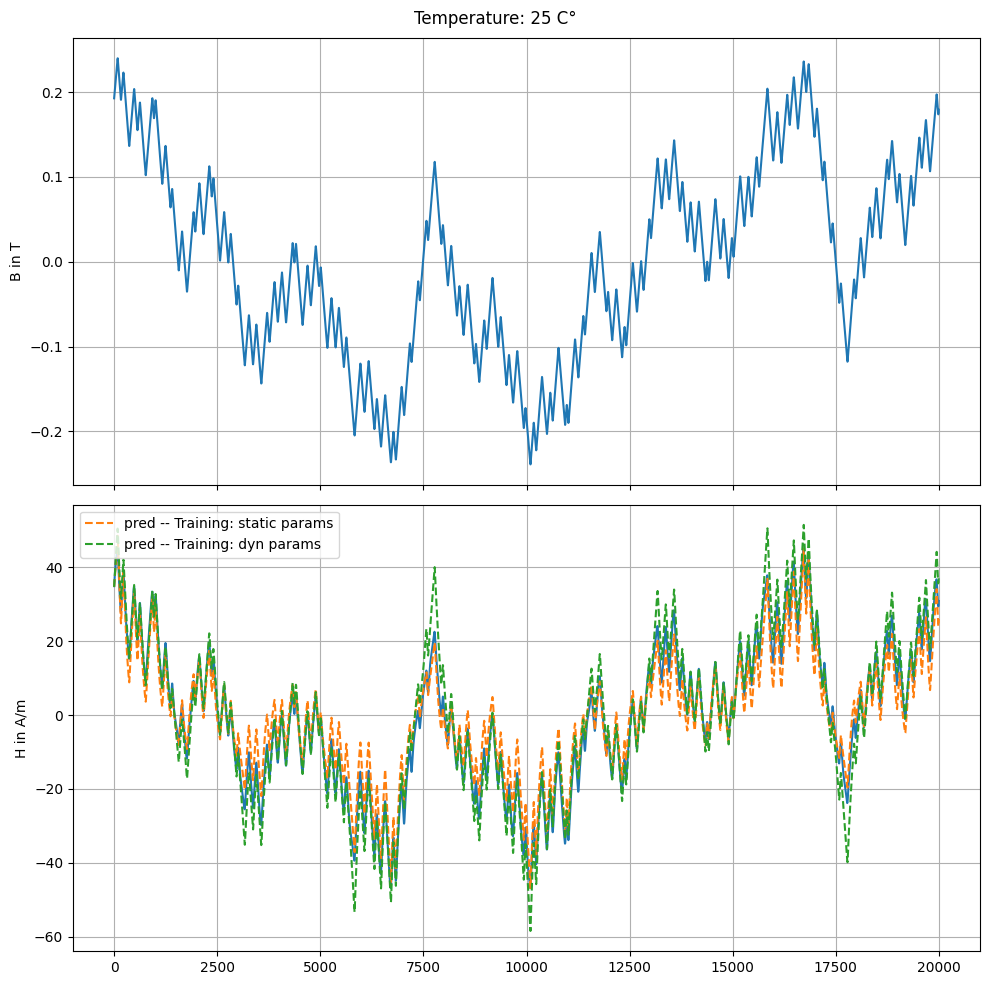

Frequency in Hz:  125000.0


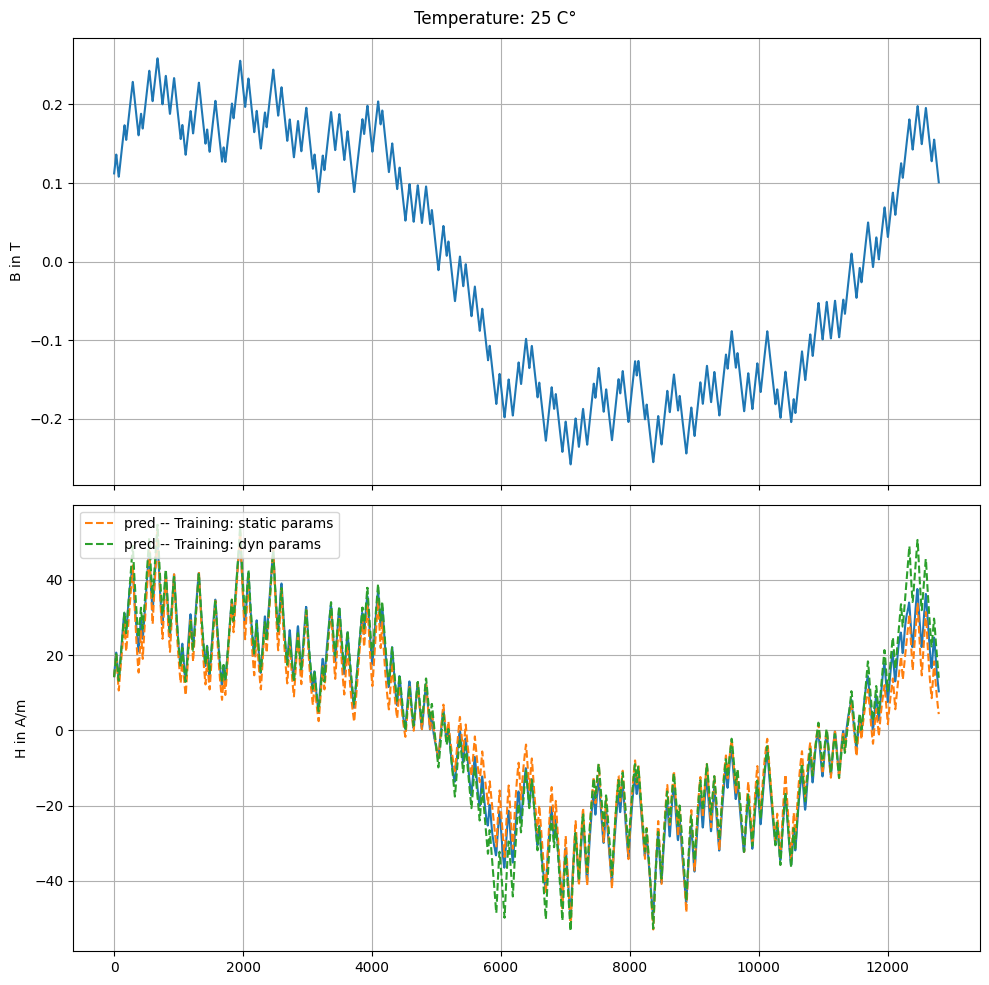

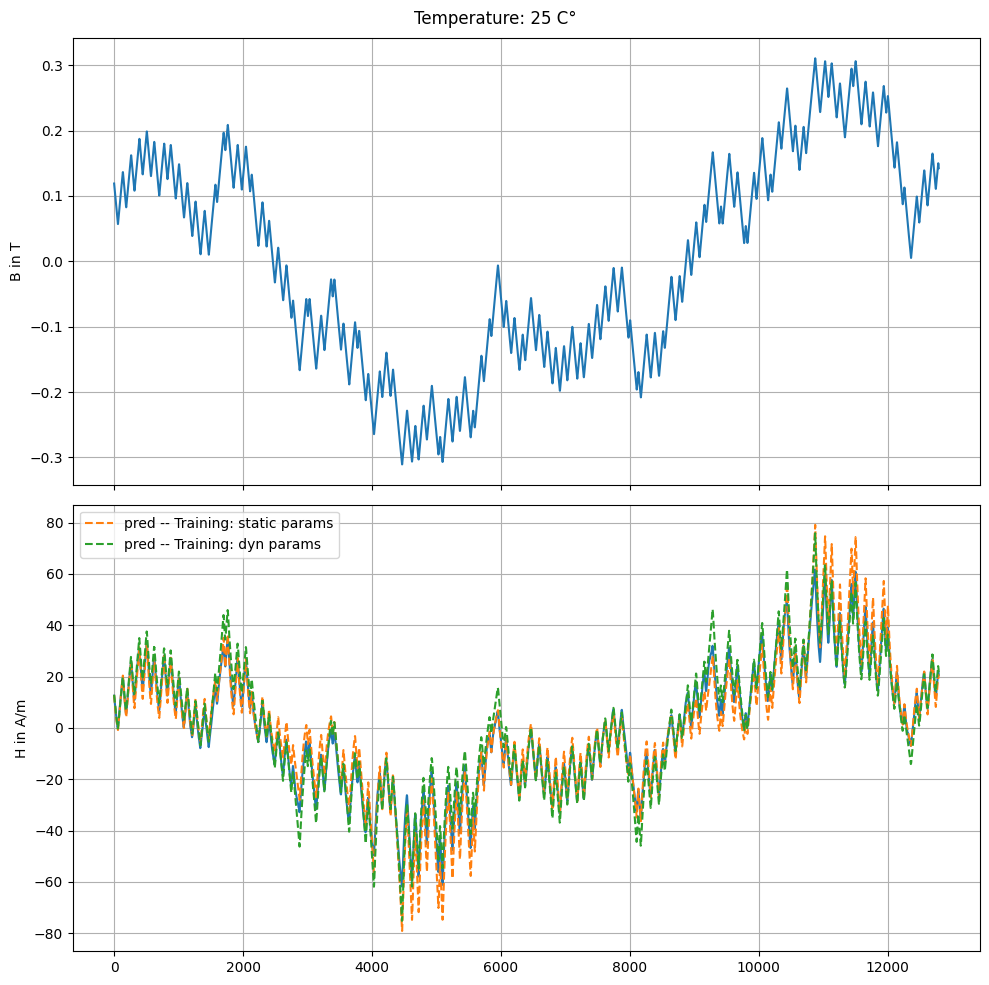

Frequency in Hz:  200000.0


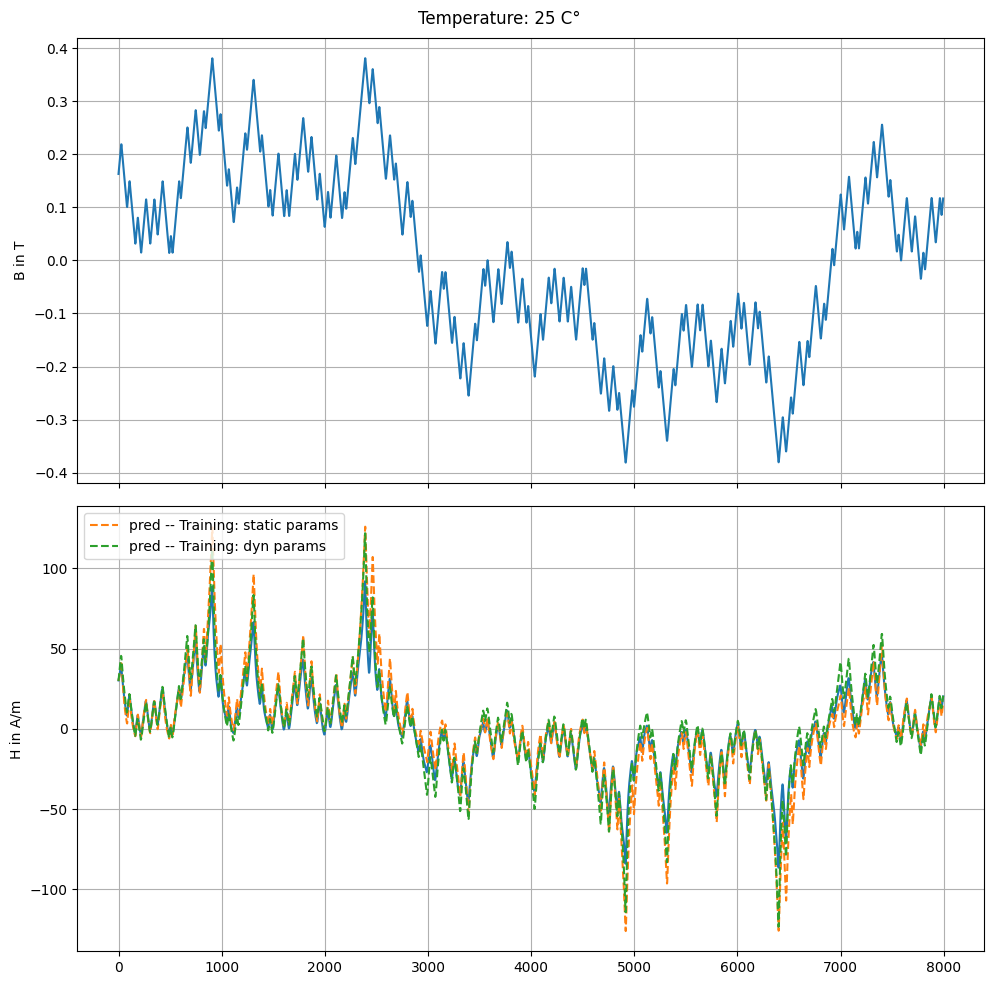

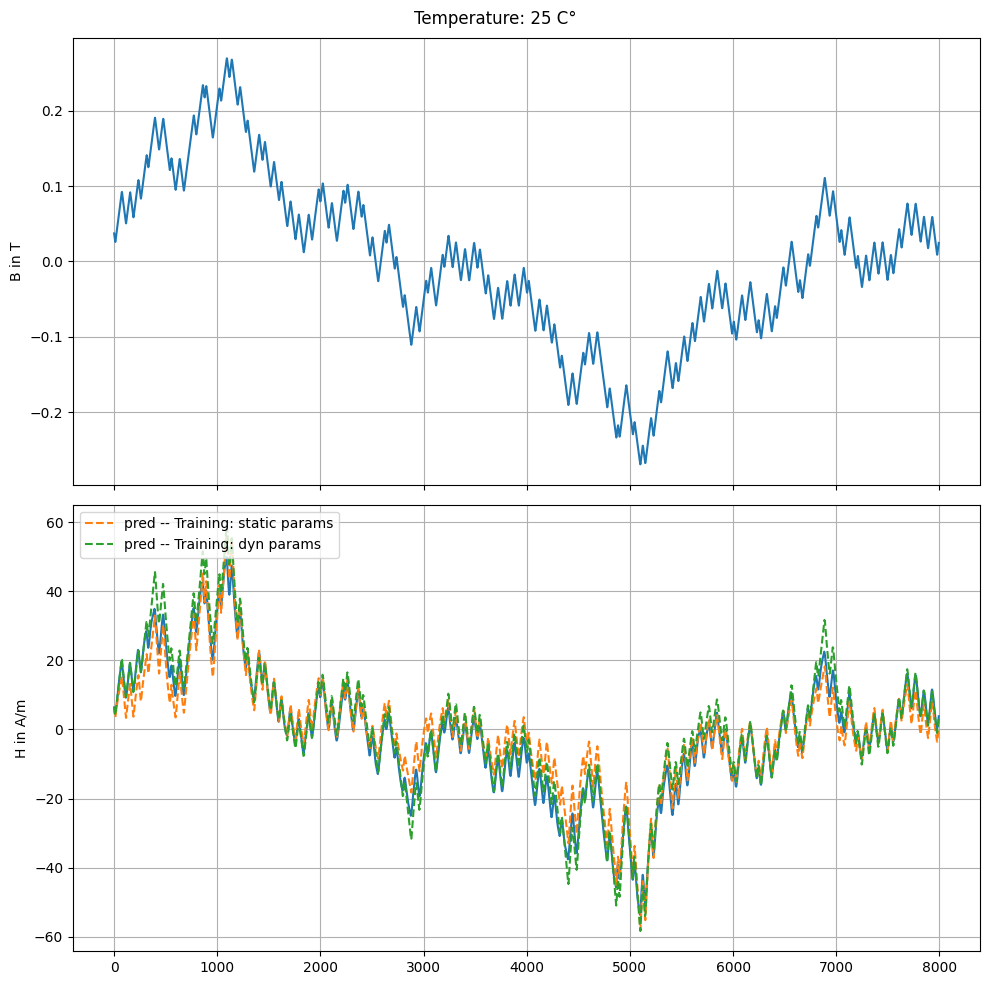

Frequency in Hz:  320000.0


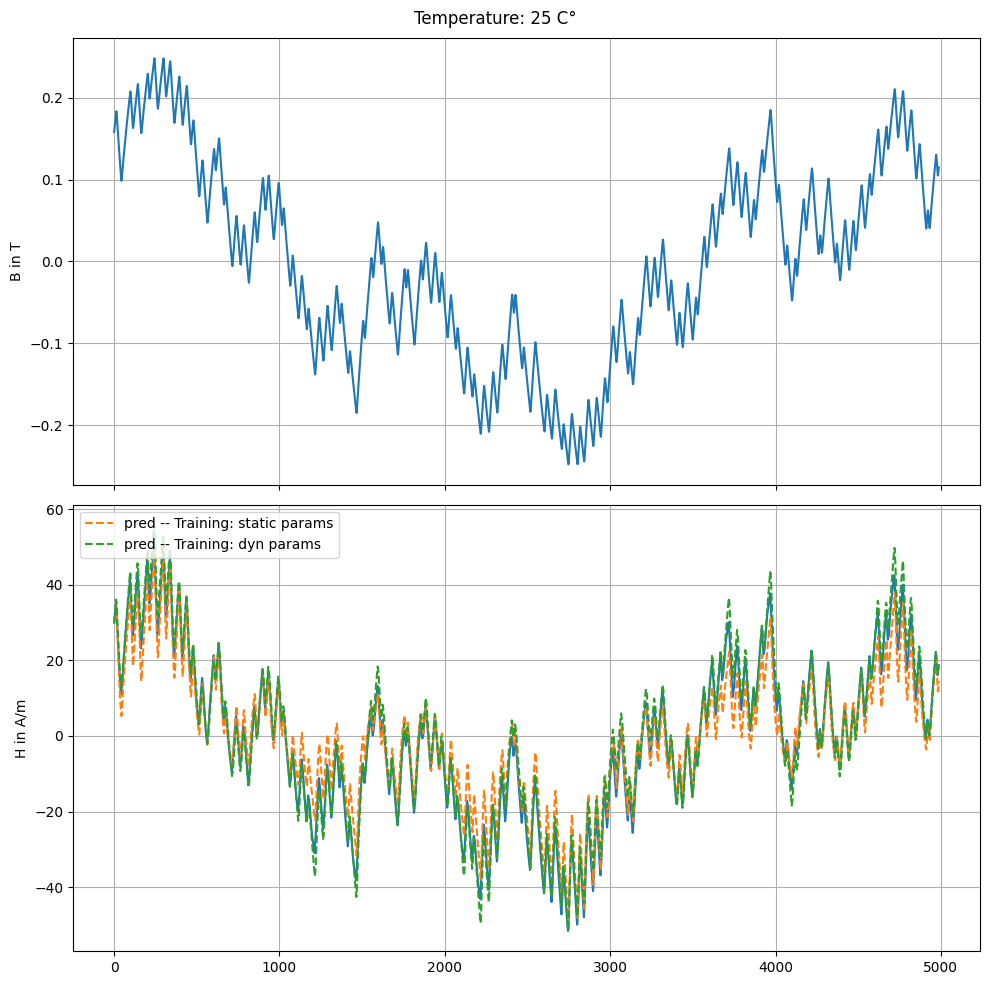

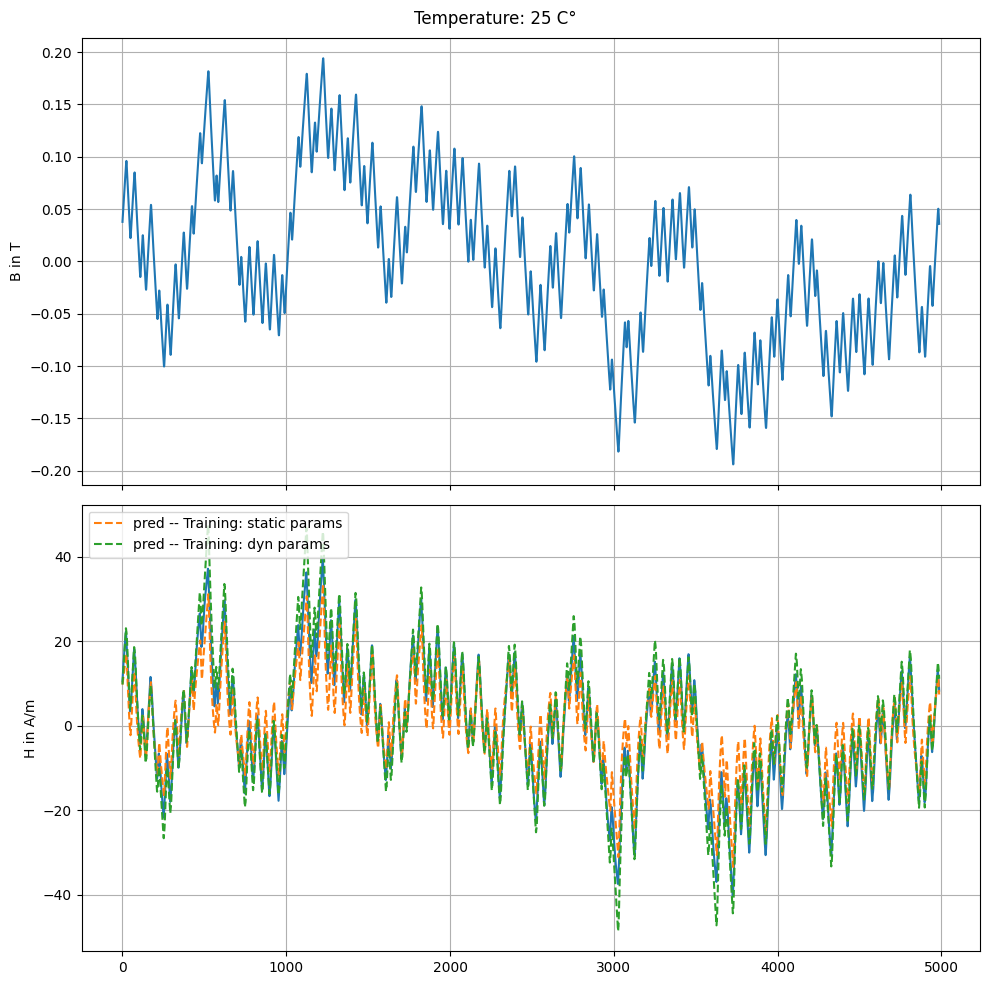

Frequency in Hz:  500000.0


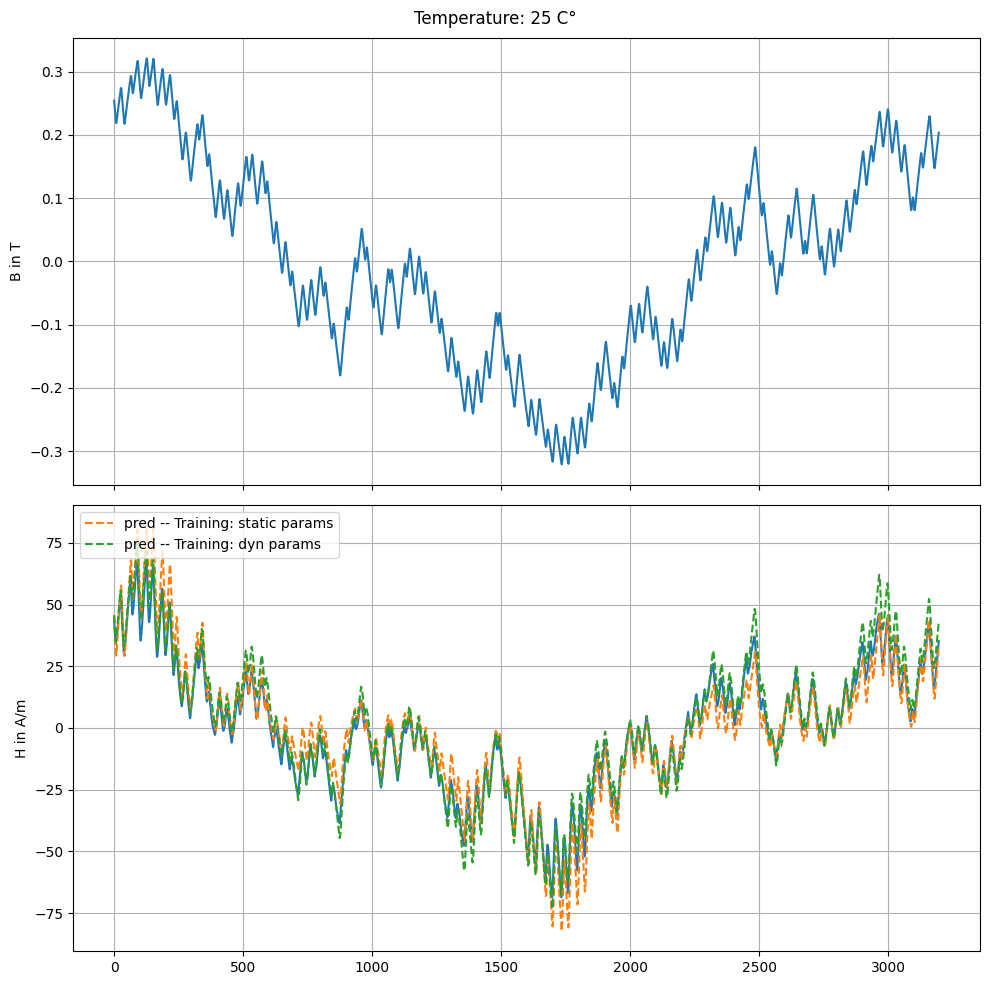

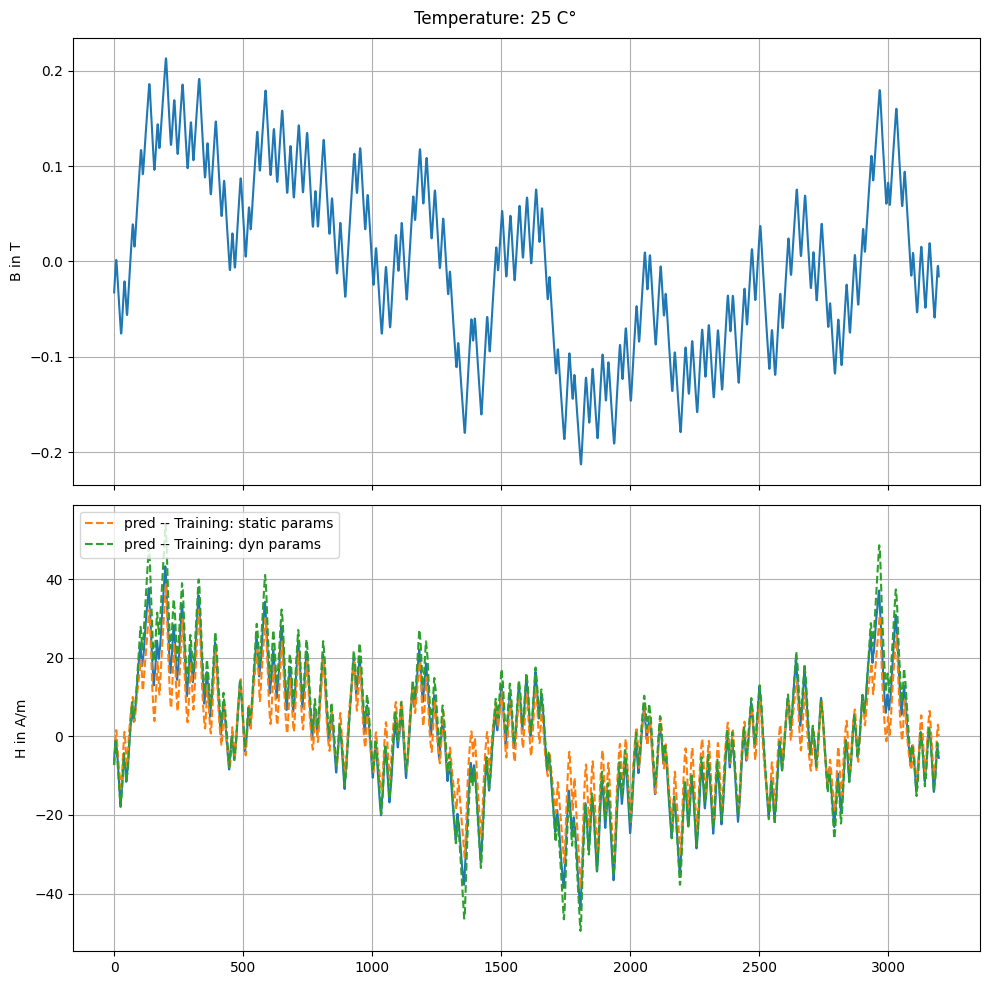

Frequency in Hz:  800000.0


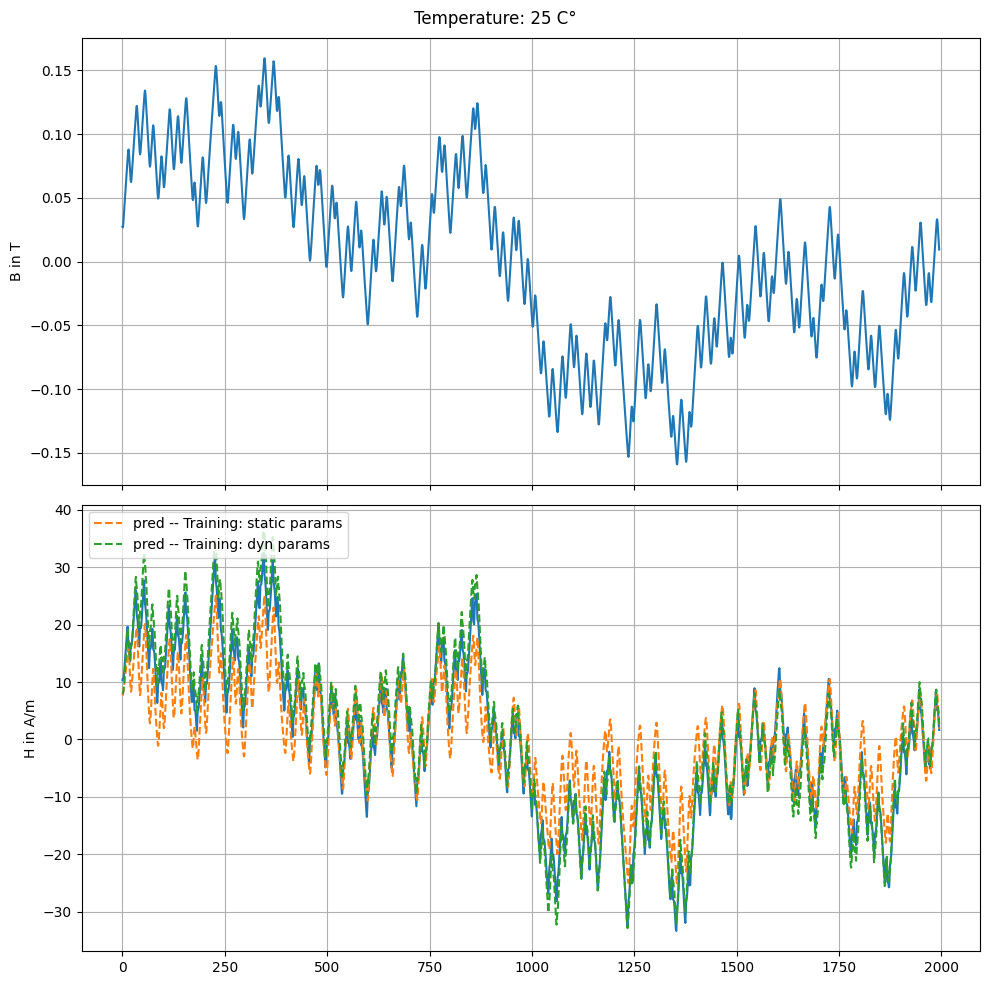

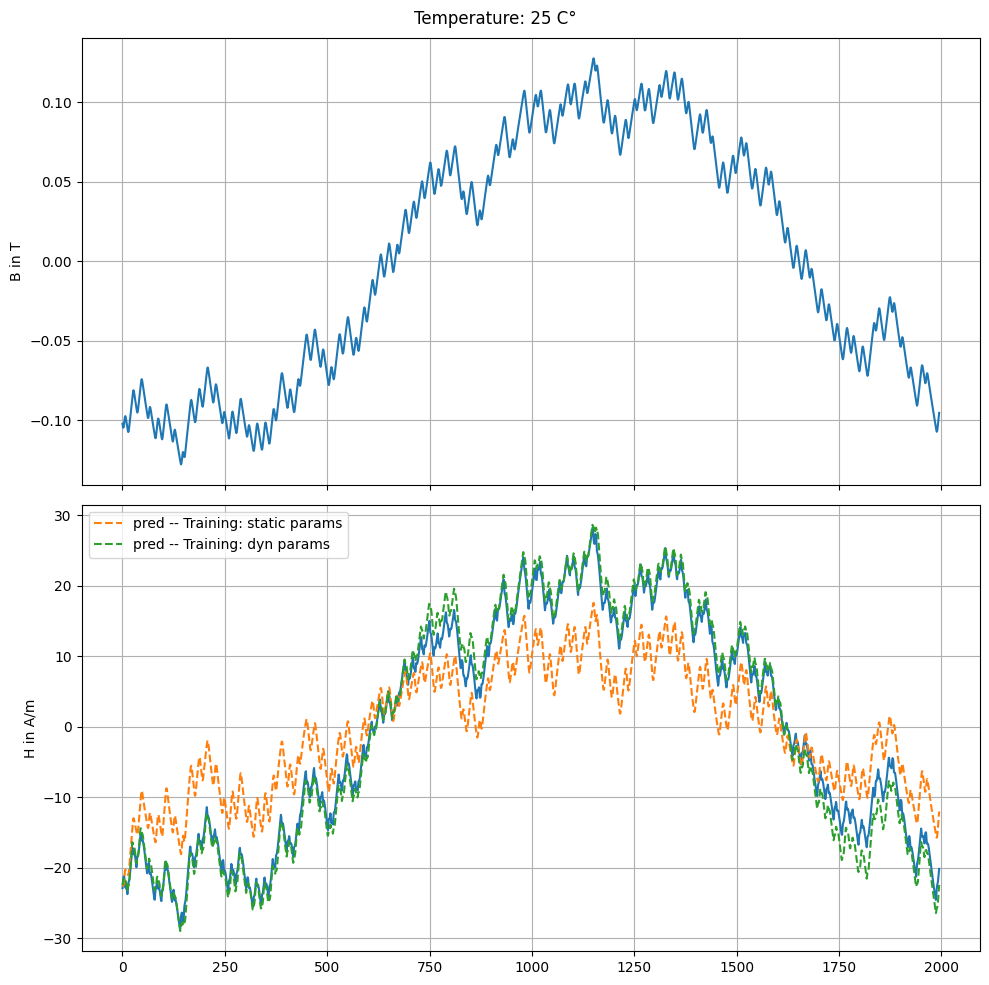

In [29]:
model_static = eqx.tree_deserialise_leaves("temp_data/model_static0.eqx", ja_wrap_static)
model_dyn = eqx.tree_deserialise_leaves("temp_data/model_dyn1.eqx", ja_wrap_dyn)
_, _, test_set = mat_set.split_into_train_val_test(
    train_frac=0.7, val_frac=0.15, test_frac=0.15, seed=12
)
test_set_T=test_set.filter_temperatures([25])
for frequency_idx in [0,1,2,3,4,5,6]:
    batch_idx=jnp.array([0,20])
    print("Frequency in Hz: ",test_set_T.frequencies[frequency_idx])
    H_pred_dyn = model_dyn(
        B_past=test_set_T[frequency_idx].B[batch_idx, :20],
        H_past=test_set_T[frequency_idx].H[batch_idx, :20],
        B_future=test_set_T[frequency_idx].B[batch_idx, 20:],
        T=test_set_T[frequency_idx].T[batch_idx]
    )#    f=test_set[frequency_idx].frequency
    H_pred_static = model_static(
        B_past=test_set_T[frequency_idx].B[batch_idx, :20],
        H_past=test_set_T[frequency_idx].H[batch_idx, :20],
        B_future=test_set_T[frequency_idx].B[batch_idx, 20:],
        T=test_set_T[frequency_idx].T[batch_idx]
    )
    for H_p_dyn,H_p_static, H, B,T in zip(H_pred_dyn,H_pred_static, test_set_T[frequency_idx].H[batch_idx, 20:], test_set_T[frequency_idx].B[batch_idx, 20:], test_set_T[frequency_idx].T[batch_idx]):

        fig, axs = plot_single_sequence(B, H, T)
        axs[-1].plot(H_p_static, label="pred -- Training: static params",linestyle="--")
        axs[-1].plot(H_p_dyn, label="pred -- Training: dyn params",linestyle="--")
        # axs[-1].plot(H_p_T, label="pred-Training: freq_idx:500_000 - T:all",linestyle="-.")
        # axs[-1].plot(H_p_all, label="pred-Training: freq_idx:all - T:all",linestyle=":")
        axs[-1].legend(loc="upper left")
        plt.show()

In [ ]:
import jax
import jax.numpy as jnp

# --- kleines Fake-GRU-Netzwerk ---
class DummyGRU:
    def __init__(self, hidden_size, input_size):
        self.hidden_size = hidden_size
        self.input_size = input_size
        # einfache Parameter (nur für Test)
        key = jax.random.key(0)
        k1, k2 = jax.random.split(key)
        self.Wxh = jax.random.normal(k1, (input_size, hidden_size))
        self.Whh = jax.random.normal(k2, (hidden_size, hidden_size))

    def __call__(self, x, h):
        # einfache nichtlineare Dynamik, kein echtes GRU
        return jnp.tanh(x @ self.Wxh + h @ self.Whh)


# --- deine Klasse mit __call__ ---
class Model:
    def __init__(self, hidden_size=4, input_size=1):
        self.net = DummyGRU(hidden_size, input_size)

    def __call__(self, inp):
        hidden = jnp.zeros(self.net.hidden_size)

        def scan_fn(carry, x):
            new_carry = self.net(x, carry)
            out = new_carry[0:1]   # z.B. nur erste Komponente ausgeben
            return new_carry, out

        _, out = jax.lax.scan(scan_fn, hidden, inp)
        return out  # shape (T,1)


# --- Testlauf ---
T = 5
inp = jnp.ones((T, 1))   # Eingabe mit shape (T,1)
model = Model(hidden_size=3, input_size=1)

out = model(inp)
print("inp.shape:", inp.shape)
print("out.shape:", out.shape)


inp.shape: (5, 1)
out.shape: (5, 1)
jac.shape: (5, 1, 5, 1)


In [3]:
diag_grads = jnp.diag(jac2d)jac

SyntaxError: invalid syntax (3511559453.py, line 1)

In [67]:
train_set, val_set, test_set = mat_set.split_into_train_val_test(
    train_frac=0.7, val_frac=0.15, test_frac=0.15, seed=12
)
train_set_norm = train_set.normalize(transform_H=True, featurize=featurize) #, feature_names=feature_names
ja_model = JilesAthertonAdv(key=model_key,in_dim=7,width=64,depth=2)
ja_wrap=JAwJAInterfaceAdv(model=ja_model, normalizer=train_set_norm.normalizer, featurize=featurize)

In [68]:
logs, model_all = train_model(
    model=ja_wrap,
    optimizer=optimizer,
    n_epochs=7,
    n_steps=0,
    material_name="3C90",
    data_tuple=(train_set, val_set, test_set),
    tbptt_size=20,#, #50
    batch_size=64,
    val_every=1,
    past_size=20,
    key=key,
    seed=seed,
)

2025-09-25 10:39:52 | INFO : train size: 12075, val size: 2596, test size: 2598


2025-09-25 10:40:19 | INFO : Test loss seed 6: inf A/m


Seed 6:   0%|          | 0/7 [00:00<?, ?epoch/s]

2025-09-25 11:02:36 | INFO : Test loss seed 6: 2710.693148 A/m


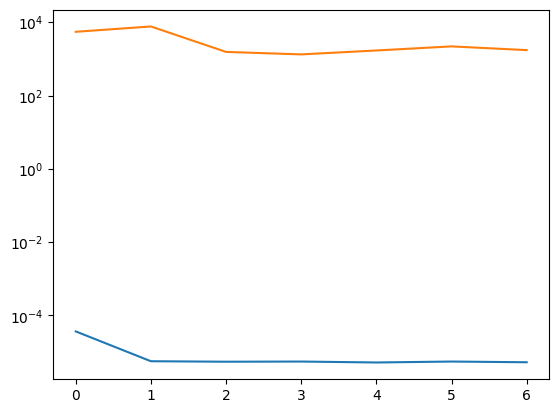

In [69]:
plt.plot(logs["loss_trends_train"],label="train_loss")
plt.plot(logs["loss_trends_val"],label="val_loss")
plt.yscale("log")

In [70]:
eqx.tree_serialise_leaves("temp_data/model_all_dyn_bigger.eqx", model_all)

In [62]:
from mc2.utils.data_inspection import (
    get_available_material_names, get_file_overview, load_and_process_single_from_full_file_overview,
)
from mc2.utils.data_plotting import plot_single_sequence, plot_hysteresis

In [63]:
def plot_single_sequence2(B, H, T, t=None, fig=None, axs=None):
    if fig is None or axs is None:
        fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    fig.suptitle("Temperature: " + str(T) + " C°")
    if t is None:
        axs[0].plot(B)
        #axs[1].plot(H)

    else:
        axs[0].plot(t, B)
        #axs[1].plot(t, H)
        for ax in axs:
            ax.set_xlabel("Time in s")

    axs[0].set_ylabel("B in T")
    axs[1].set_ylabel("H in A/m")

    for ax in axs:
        ax.grid()

    fig.tight_layout()
    return fig, axs

Frequency in Hz:  500000.0


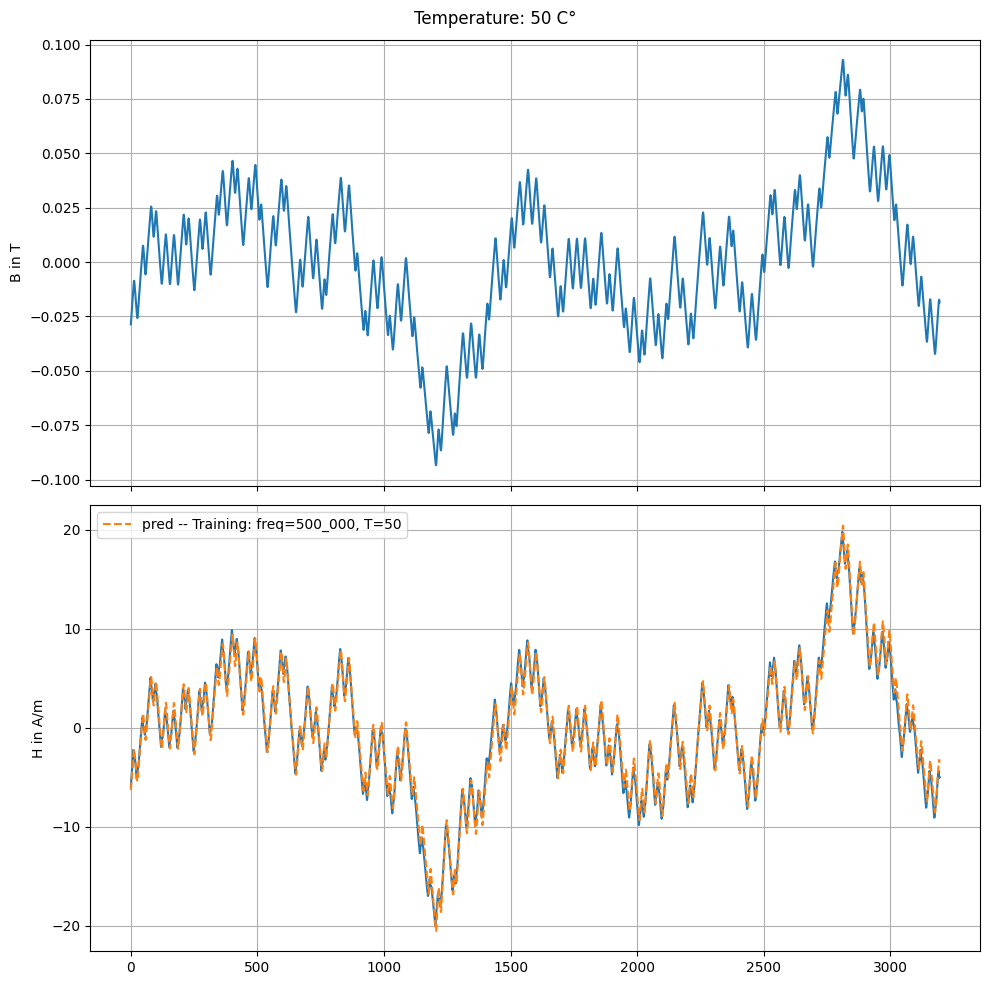

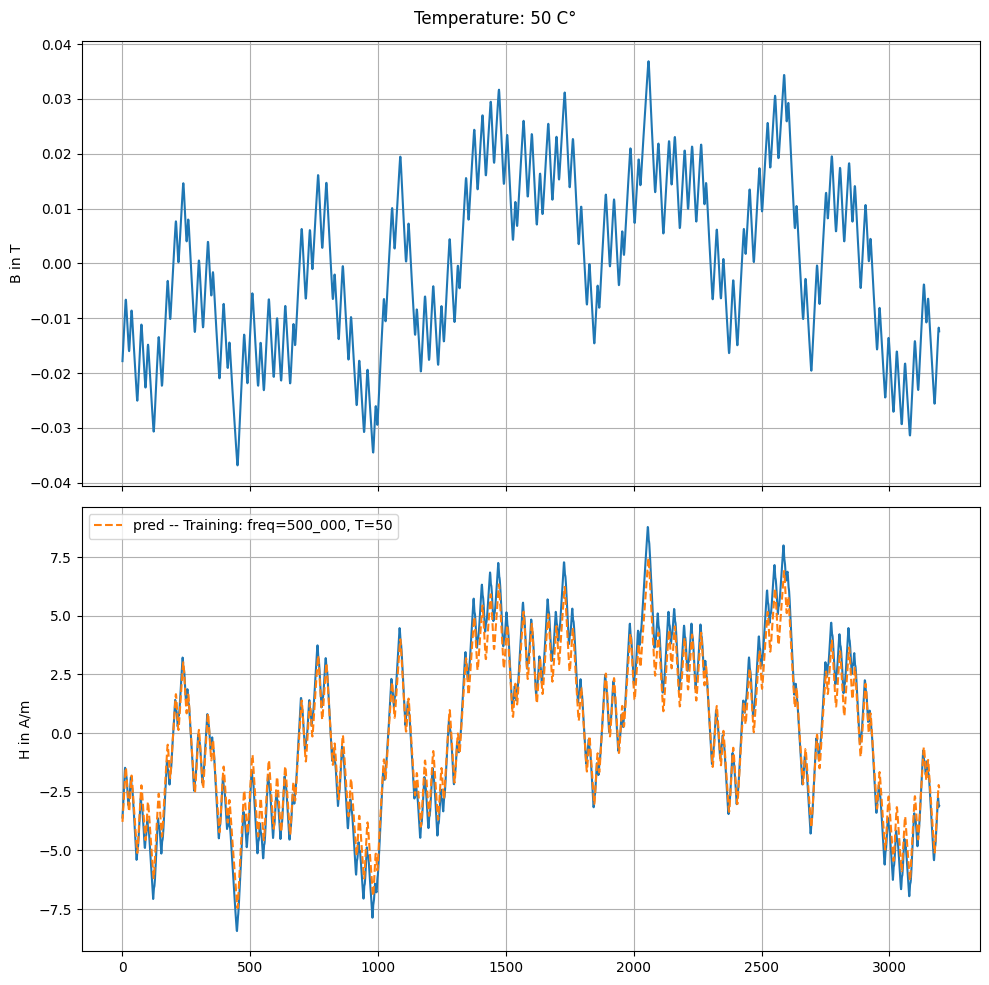

In [ ]:
model_T_f = eqx.tree_deserialise_leaves("temp_data/model_T_f_dyn.eqx", ja_wrap)
train_set, val_set, test_set = mat_set.split_into_train_val_test(
    train_frac=0.7, val_frac=0.15, test_frac=0.15, seed=12
)
test_set_T=test_set.filter_temperatures([50])
for frequency_idx in [5]:
    batch_idx=jnp.array([0,20])
    print("Frequency in Hz: ",test_set_T.frequencies[frequency_idx])
    H_pred_T_f = model_T_f(
        B_past=test_set_T[frequency_idx].B[batch_idx, :20],
        H_past=test_set_T[frequency_idx].H[batch_idx, :20],
        B_future=test_set_T[frequency_idx].B[batch_idx, 20:],
        T=test_set_T[frequency_idx].T[batch_idx]
    )#    f=test_set[frequency_idx].frequency
    
    for H_p_T_f, H, B,T in zip(H_pred_T_f, test_set_T[frequency_idx].H[batch_idx, 20:], test_set_T[frequency_idx].B[batch_idx, 20:], test_set_T[frequency_idx].T[batch_idx]):

        fig, axs = plot_single_sequence(B, H, T)
        axs[-1].plot(H_p_T_f, label="pred -- Training: freq=500_000, T=50",linestyle="--")
        # axs[-1].plot(H_p_T, label="pred-Training: freq_idx:500_000 - T:all",linestyle="-.")
        # axs[-1].plot(H_p_all, label="pred-Training: freq_idx:all - T:all",linestyle=":")
        axs[-1].legend(loc="upper left")
        plt.show()

Frequency in Hz:  50000.0


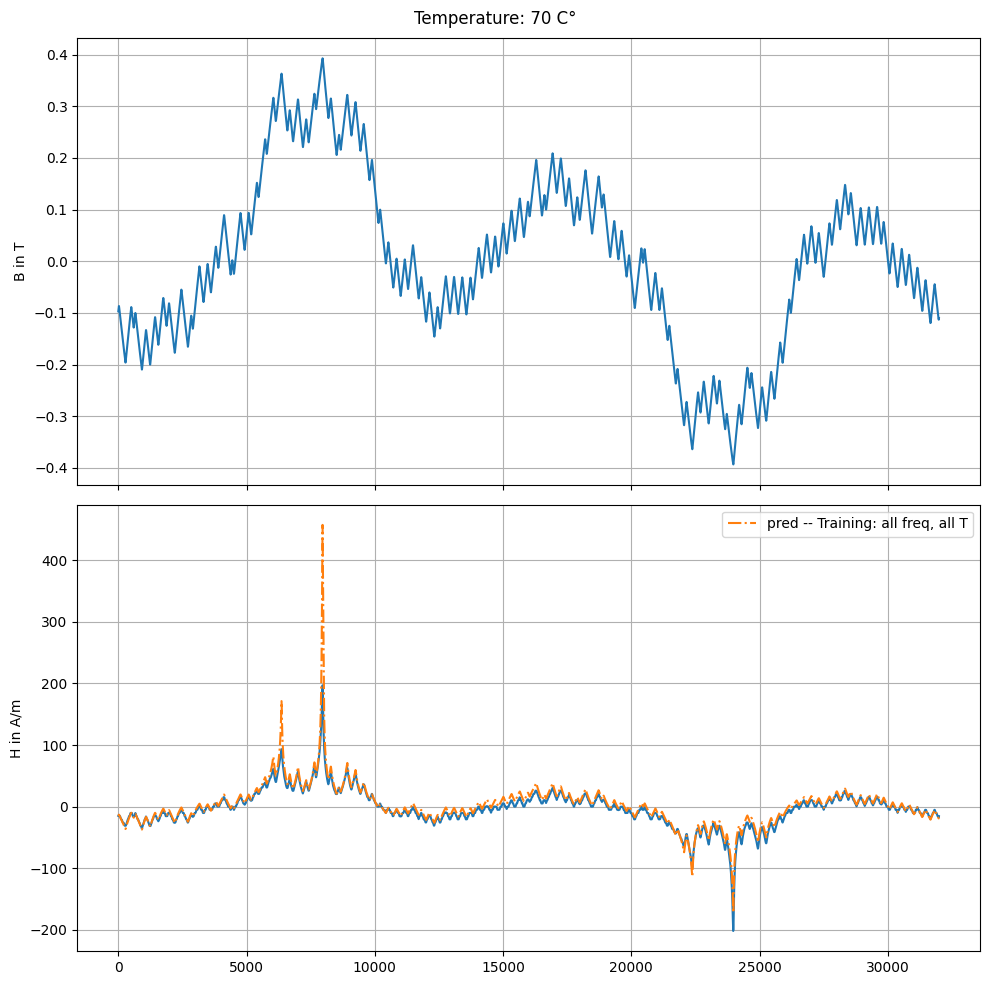

Frequency in Hz:  80000.0


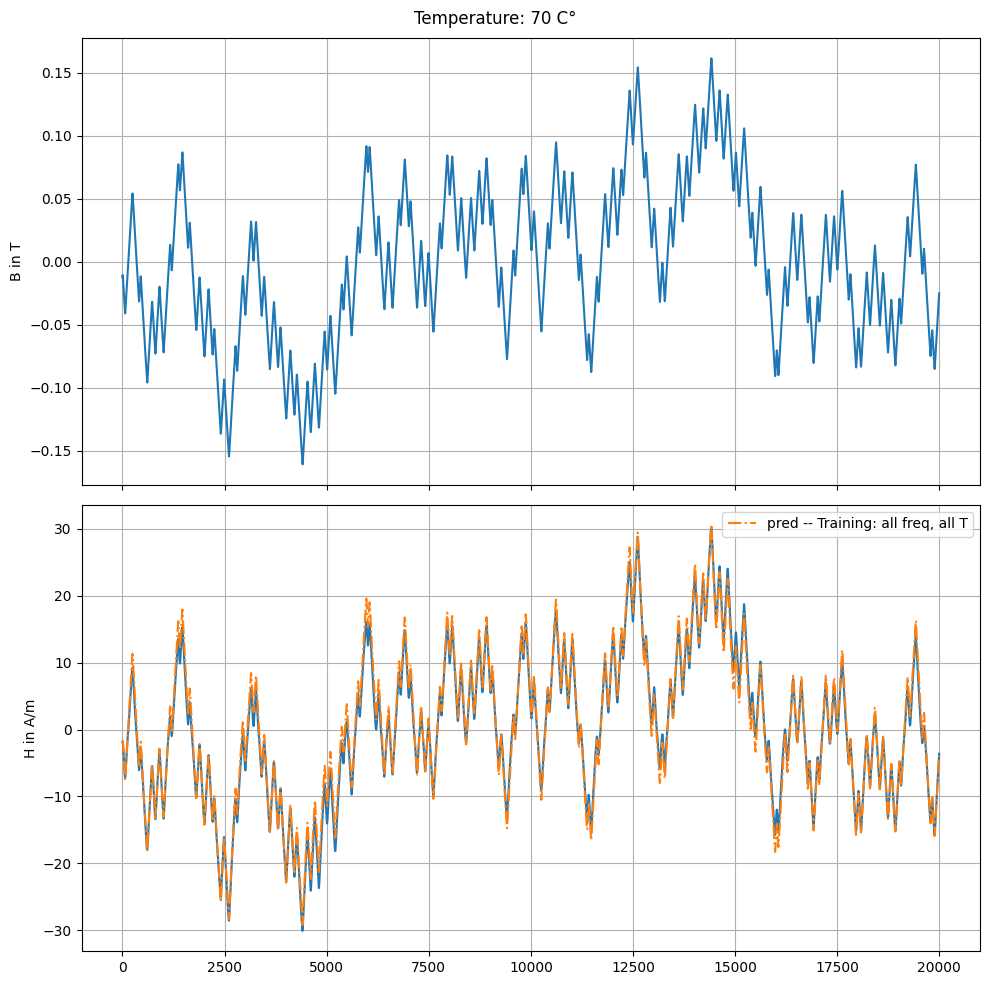

Frequency in Hz:  125000.0


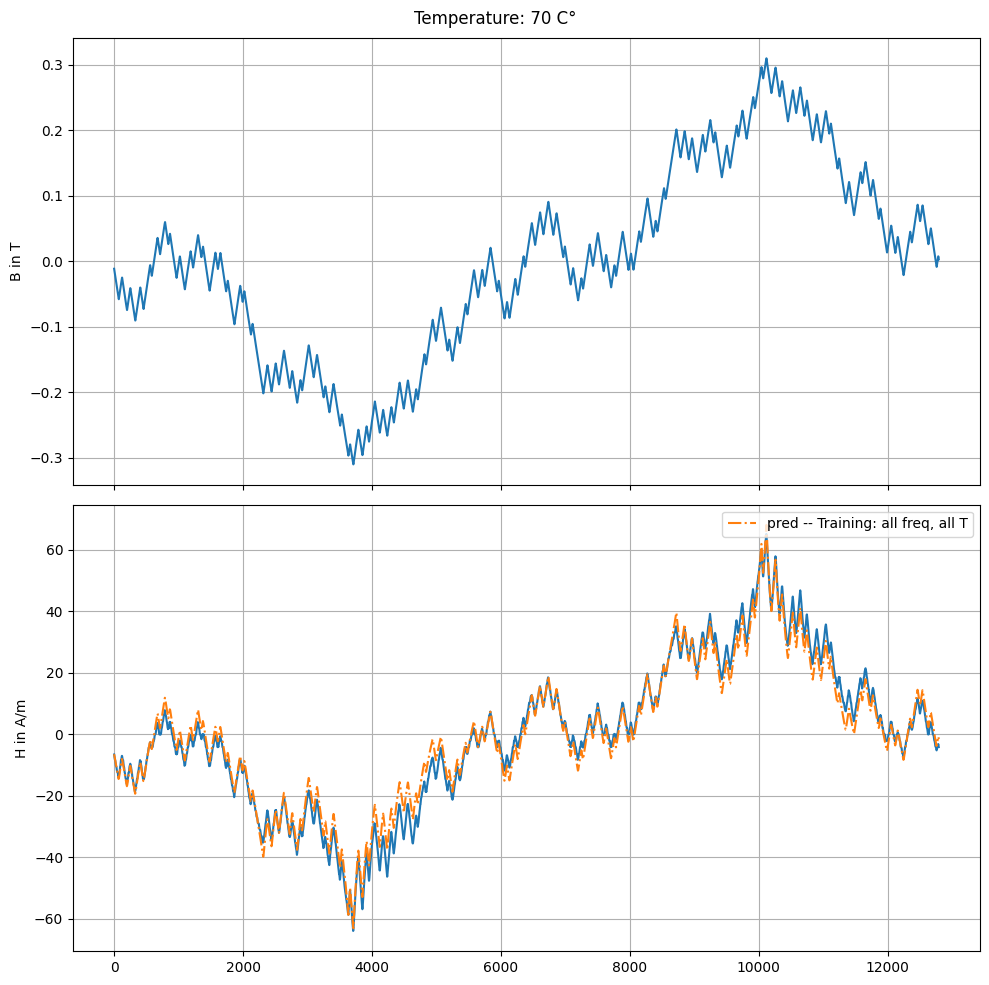

Frequency in Hz:  200000.0


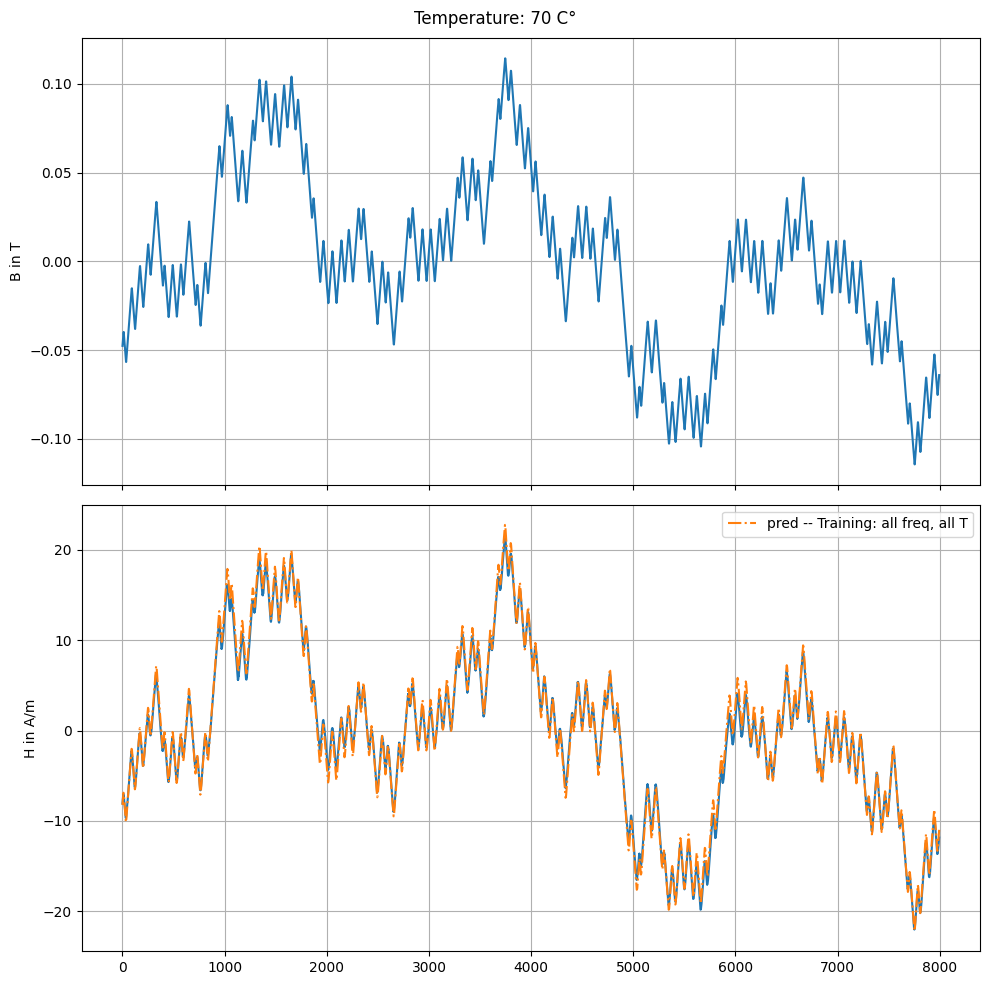

Frequency in Hz:  320000.0


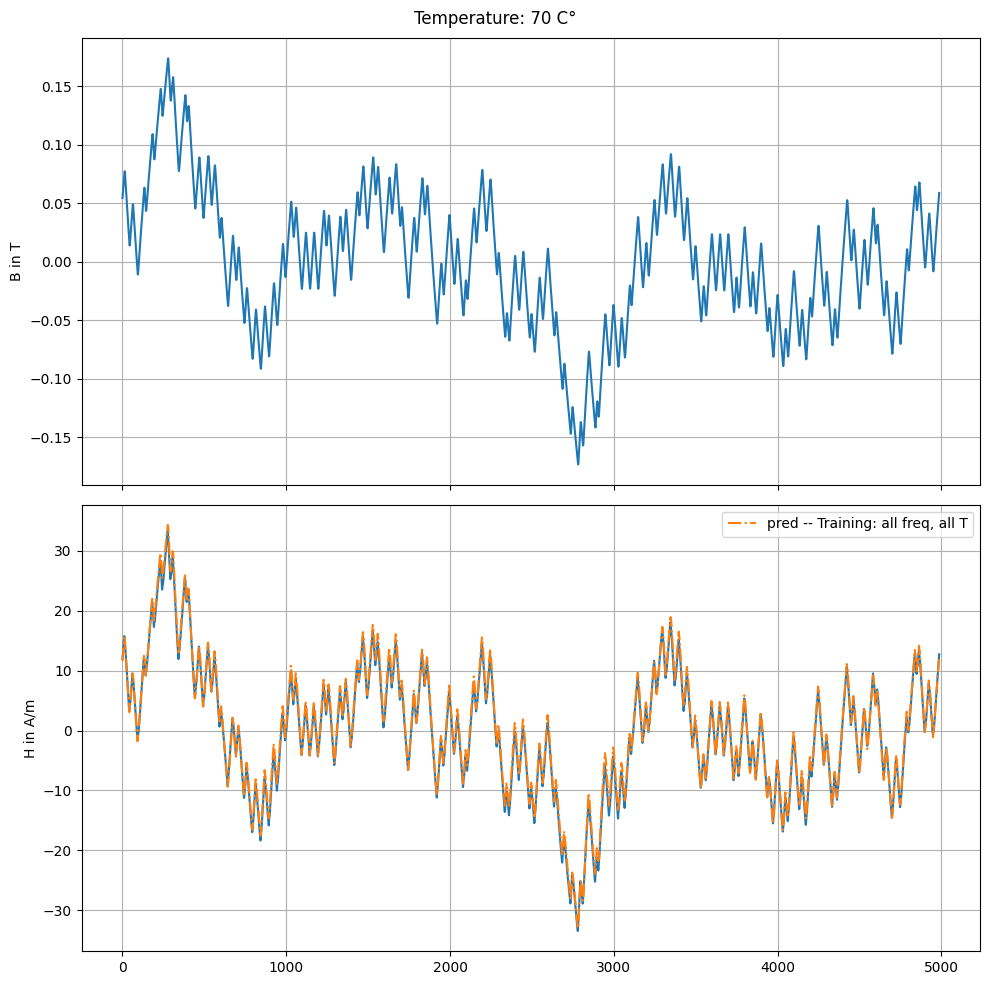

Frequency in Hz:  500000.0


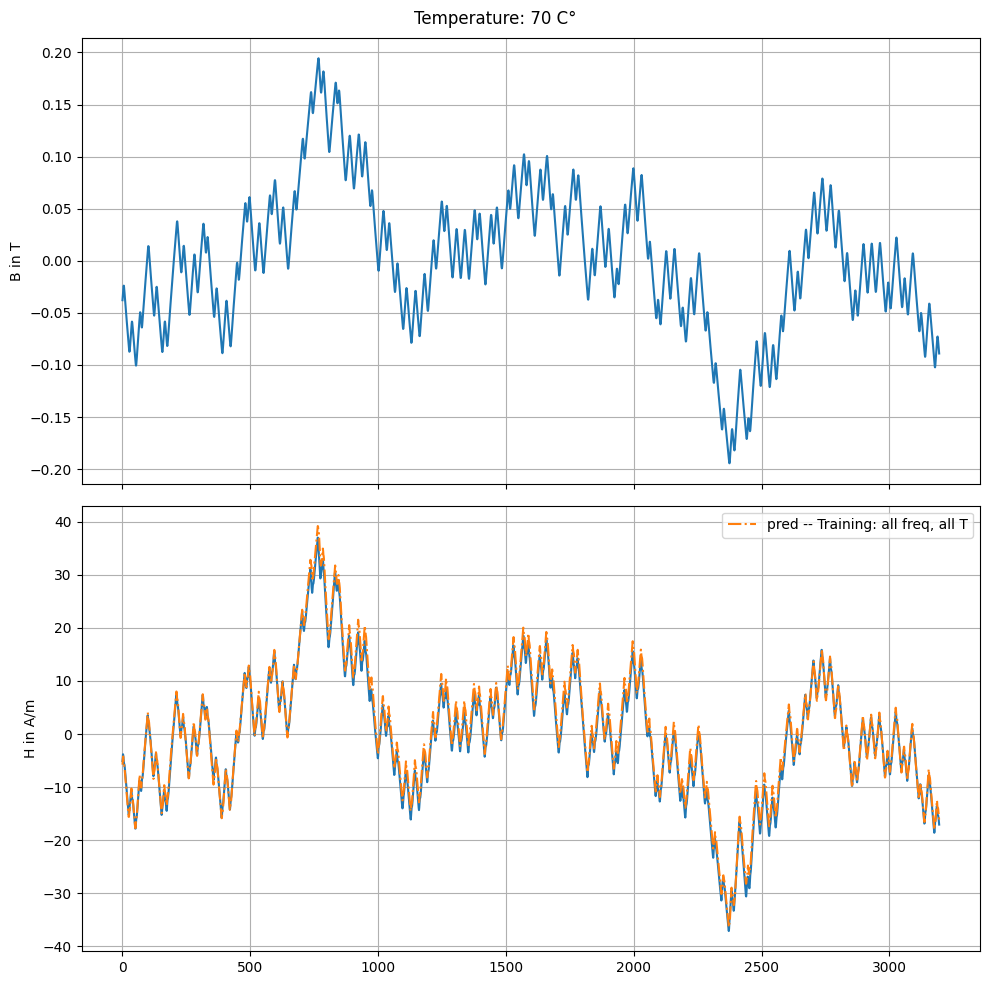

Frequency in Hz:  800000.0


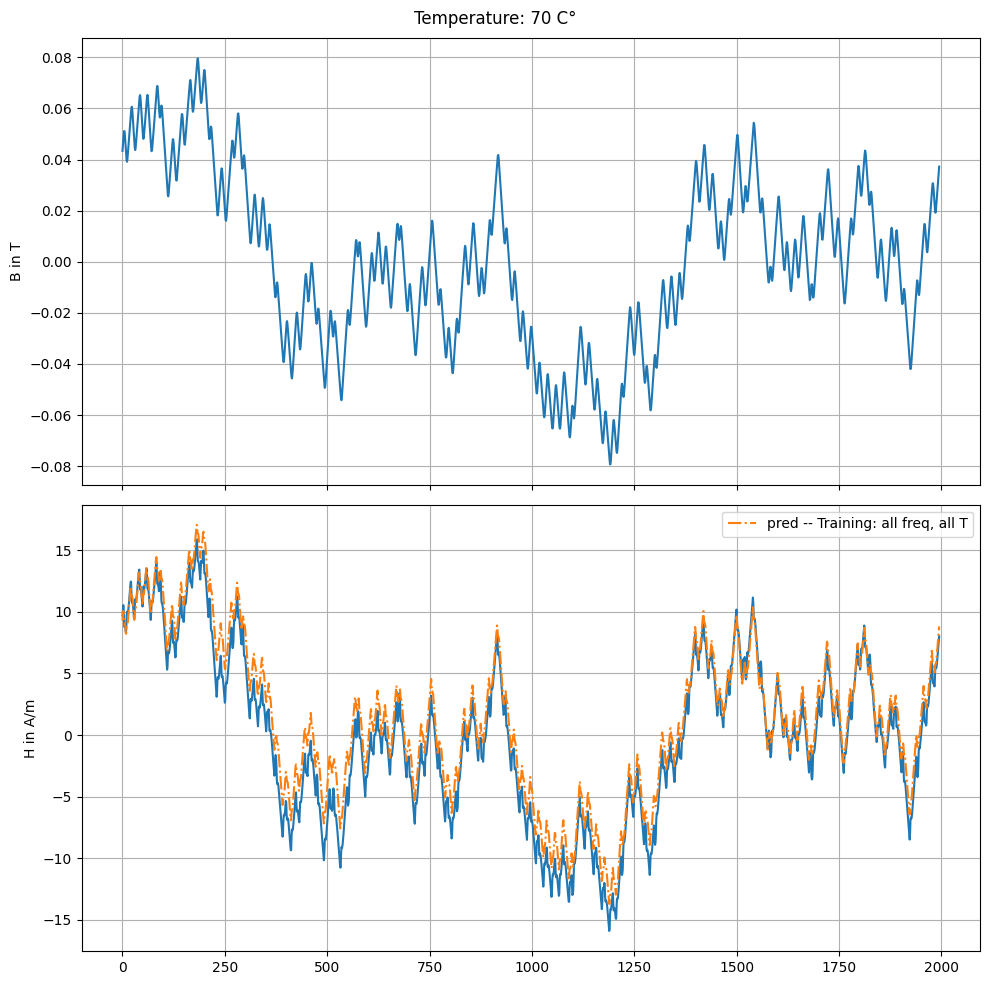

In [71]:
# model_T_f = eqx.tree_deserialise_leaves("temp_data/model_T_f.eqx", ja_wrap)
# model_all_T= eqx.tree_deserialise_leaves("temp_data/model_all_T.eqx", ja_wrap)
# ja_model = JilesAthertonAdv(key=model_key,in_dim=7)
# ja_wrap=JAwJAInterfaceAdv(model=ja_model, normalizer=train_set_norm.normalizer, featurize=featurize)
# model_all = eqx.tree_deserialise_leaves("temp_data/model_all_dyn.eqx", ja_wrap)
ja_model = JilesAthertonAdv(key=model_key,in_dim=7,width=64,depth=2)
ja_wrap=JAwJAInterfaceAdv(model=ja_model, normalizer=train_set_norm.normalizer, featurize=featurize)
model_all = eqx.tree_deserialise_leaves("temp_data/model_all_dyn_bigger.eqx", ja_wrap)
test_set_T=test_set.filter_temperatures([70])
for frequency_idx in [0,1,2,3,4,5,6]:
    batch_idx=jnp.array([0])
    print("Frequency in Hz: ",test_set_T.frequencies[frequency_idx])
    H_pred_all = model_all(
        B_past=test_set_T[frequency_idx].B[batch_idx, :20],
        H_past=test_set_T[frequency_idx].H[batch_idx, :20],
        B_future=test_set_T[frequency_idx].B[batch_idx, 20:],
        T=test_set_T[frequency_idx].T[batch_idx]
    )#
    for H_p_all, H, B,T in zip(H_pred_all, test_set_T[frequency_idx].H[batch_idx, 20:], test_set_T[frequency_idx].B[batch_idx, 20:], test_set_T[frequency_idx].T[batch_idx]):

        fig, axs = plot_single_sequence(B, H, T)
        #axs[-1].plot(H_p_T_f, label="pred -- Training: freq=500_000, T=50",linestyle="--")
        #axs[-1].plot(H_p_T, label="pred -- Training: freq=500_000, all T",linestyle="-.")
        axs[-1].plot(H_p_all, label="pred -- Training: all freq, all T",linestyle="-.")
        #axs[-1].set_title(test_set_T.frequencies[frequency_idx])
        axs[-1].legend(loc="upper right")
        plt.show()